In [1]:
import settings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob

def clean_columns(df):
    if 'seed' in df: del df['seed']
    if 'run' in df: del df['run']
    if 'time' in df: del df['time']
    if 'parameters' in df: del df['parameters']
    if 'Unnamed: 0' in df: del df['Unnamed: 0']
    return df

def remove_substring_from_params(x, string, chars_right):
    pos = x.find(string)
    if pos > -1:
        return x[:pos] + x[pos + len(string) + chars_right:]
    return x

sns.set_theme(style="whitegrid")

PATH_TO_SIMULATED_RESULTS = os.path.join(
    '/Users/michi/Projects/unpast/scratch/data/simulated_data')
PATH_TO_REAL_RESULTS = os.path.join(
    '/Users/michi/Projects/unpast/scratch/data/real_data')

PATH_TO_SIMULATED_DATA = os.path.join(
    '/Users/michi/Projects/unpast/scratch/data/simulated_input')


In [2]:
# some files are named TCGA-BRCA instead of TCGA
# rename files from TCGA-BRCA to TCGA

for file_path_tcga in glob.glob(os.path.join(PATH_TO_REAL_RESULTS, '*TCGA-BRCA.tsv')):
    new_file_path = file_path_tcga.replace('TCGA-BRCA', 'TCGA')
    os.rename(file_path_tcga, new_file_path)

In [3]:
# reformat mclust files to correct format
# for file_path in glob.glob(os.path.join(PATH_TO_RESULTS, 'mclust_*.tsv')):
#     df = pd.read_csv(file_path, sep='\t', index_col=0)
#     if 'seed' in df.columns:
#         del df['seed']
#         df['parameters'] = df['parameters'].map(lambda x: f'seed={x}')
#         df.to_csv(file_path, sep='\t')


In [4]:
# best average rank in BRCA

import pandas as pd

table_key = 'PAM50'
found_methods = set()
best_average_rank_brca = {}
best_average_rank_brca_string = {}

for method in settings.METHODS:
    
    file_path_tcga = os.path.join(PATH_TO_REAL_RESULTS, f'{method}_TCGA.tsv')
    file_path_metabric = os.path.join(
        PATH_TO_REAL_RESULTS, f'{method}_METABRIC.tsv')
    
    try:
        df_meta = pd.read_csv(file_path_metabric, sep='\t')
        df_tcga = pd.read_csv(file_path_tcga, sep='\t')
    except FileNotFoundError:
        print(f'Could not find files for {method}.')
        continue
    df_meta = df_meta.dropna(subset='parameters')
    df_tcga = df_tcga.dropna(subset='parameters')
    
    df_meta['parameters'] = df_meta['parameters'].map(str)
    df_tcga['parameters'] = df_tcga['parameters'].map(str)
    
    # remove random state from params
    df_meta['parameters'] = df_meta['parameters'].map(lambda x: ';'.join([y for y in x.split(';') if not y.startswith('random_state=')]))
    df_tcga['parameters'] = df_tcga['parameters'].map(lambda x: ';'.join([y for y in x.split(';') if not y.startswith('random_state=')]))
    
    # merge runs
    df_meta = df_meta.groupby('parameters').mean()
    df_tcga = df_tcga.groupby('parameters').mean()
    
    df_meta = df_meta.sort_values(table_key, ascending=False)
    df_meta['rank'] = list(range(len(df_meta.index)))
    
    df_tcga = df_tcga.sort_values(table_key, ascending=False)
    df_tcga['rank'] = list(range(len(df_tcga.index)))
    
    # in some cases (kmeans) we have not the same parameters in both datasets
    index_shared = df_tcga.index[df_tcga.index.isin(df_meta.index)]
    df_tcga = df_tcga[df_tcga.index.isin(index_shared)]
    df_meta = df_meta[df_meta.index.isin(index_shared)]
    
    df = pd.concat([df_tcga, df_meta]).groupby('parameters').sum()
    
    params = df.sort_values('rank', ascending=True).index[0]

    
    print(method)
    print(params)
    
    d = {}
    if ';' in params: 
        sep = ';'
    else:
        sep = '-'
    for x in params.split(sep):
        if not len(x):
            continue
        key, value = x.split('=') 
        try:
            value = eval(value)
        except:
            pass
        d[key] = value
    best_average_rank_brca_string[method] = params
    best_average_rank_brca[method] =d

UnPaSt
bin=kmeans;pval=0.01;direction=UP-DOWN;clust=WGCNA;dch=0.995;ds=3;preClustering=T
kmeans
k=3;max_iter=1000;init=k-means++;tol=0.0001
BisectingKMeans
k=7;max_iter=300;tol=0.0001;bisecting_strategy=largest_cluster
MiniBatchKMeans
k=4;max_iter=300;batch_size=500;max_no_improvement=20;reassignment_ratio=0.005
HierarchicalClustering
k=6;linkage=ward
AffinityPropagation
damping=0.97;max_iter=200
Could not find files for AgglomerativeClustering.
BIRCH
k=6;branching_factor=10;threshold=0.5
DBSCAN
eps=150;min_samples=5
GMM
covtype=spherical;initmethod=kmeans;k=4
SpectralClustering
k=4;n_neighbors=5;assign_labels=cluster_qr;n_inits=10
Could not find files for Optics.
MeanShift
max_iters=1000;cluster_all=False;min_bin_freq=1
mclust
k=5
NMF
k=8;init=nndsvda;tol=0.0001;transposed=False;alpha_W=-0.1;alpha_H=0.0;shuffle=False;solver=cd;beta_loss=frobenius;max_iter=200;
sparse_PCA
n_components=16;alpha=1;ridge_alpha=0.1;max_iter=1000;method=cd;tol=1e-08;
iClusterPlus
lambda_n=25;n_cluster=3;lam

In [5]:
# best params in tcga and metabric

best_params = {d: {} for d in settings.REAL_DATASETS}

table_key = 'PAM50'
found_methods = set()
for dataset in settings.REAL_DATASETS:
    for method in settings.METHODS:
        try:
            df = pd.DataFrame()
            file_path = os.path.join(
                PATH_TO_REAL_RESULTS, f'{method}_{dataset}.tsv')
            df_cur = pd.read_csv(file_path, sep='\t')
            df_cur = df_cur.rename(columns={'param': 'parameters'})
            if 'seed' not in df_cur.columns and 'seeds=' in df_cur.iloc[0]['parameters']:
                # assumes that seeds= is last parameter, grandforest
                df_cur['seed'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[-1])
                df_cur['run'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[-1])
                df_cur['parameters'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[0])
            
            df_cur = df_cur.dropna(axis=0, subset=['parameters'])
            df_cur['dataset'] = dataset
            df = pd.concat([df, df_cur])
        except:
            print(f'Warning: No file found for {method} on real data.')
            continue
            
        found_methods.add(method)
        # merge runs with different seeds
        if 'run' in df or not df["parameters"].is_unique:
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'random_state=', 1))
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'TCGA', 0))
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'METABRIC', 0))
            df_mean = df.groupby('parameters').mean()
        else:
            df_mean = df.set_index('parameters')
        df_mean = clean_columns(df_mean)
        df_mean = df_mean[table_key]
        top_params = df_mean.sort_values(ascending=False).index[0]
        best_params[dataset][method] = top_params

# Figure3: Simulated data (Average best parameters)

	co-exprs. module  500 r= 0.5017306064916428
	co-exprs. module  500 r= 0.5044481410597403
	co-exprs. module  500 r= 0.5635685633423761
	co-exprs. module  500 r= 0.5130916804581102
UnPaSt bin=GMM;pval=0.05;direction=UP-DOWN;clust=WGCNA;dch=0.995;ds=0;preClustering=T
   method     value
0  UnPaSt  0.944947
1  UnPaSt  0.944444
2  UnPaSt  0.944444
3  UnPaSt  0.944444
4  UnPaSt  0.944947
   method value
0  UnPaSt   1.0
1  UnPaSt   1.0
2  UnPaSt   1.0
3  UnPaSt   1.0
4  UnPaSt   1.0
   method value
0  UnPaSt   1.0
1  UnPaSt   1.0
2  UnPaSt   1.0
3  UnPaSt   1.0
4  UnPaSt   1.0
   method     value
0  UnPaSt  0.944444
1  UnPaSt  0.944444
2  UnPaSt  0.944444
3  UnPaSt  0.944444
4  UnPaSt  0.944444
   method value
0  UnPaSt   1.0
1  UnPaSt   1.0
2  UnPaSt   1.0
3  UnPaSt   1.0
4  UnPaSt   1.0
   method value
0  UnPaSt   1.0
1  UnPaSt   1.0
2  UnPaSt   1.0
3  UnPaSt   1.0
4  UnPaSt   1.0
   method     value
0  UnPaSt  0.944444
1  UnPaSt  0.944444
2  UnPaSt  0.944444
3  UnPaSt  0.950352
4  UnPaSt 

/var/folders/k5/qbs_42rd35j4mmpzqs47hdrw0000gn/T/ipykernel_38792/2966852194.py:303: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[i].set_color(color)


<Figure size 18x180 with 0 Axes>

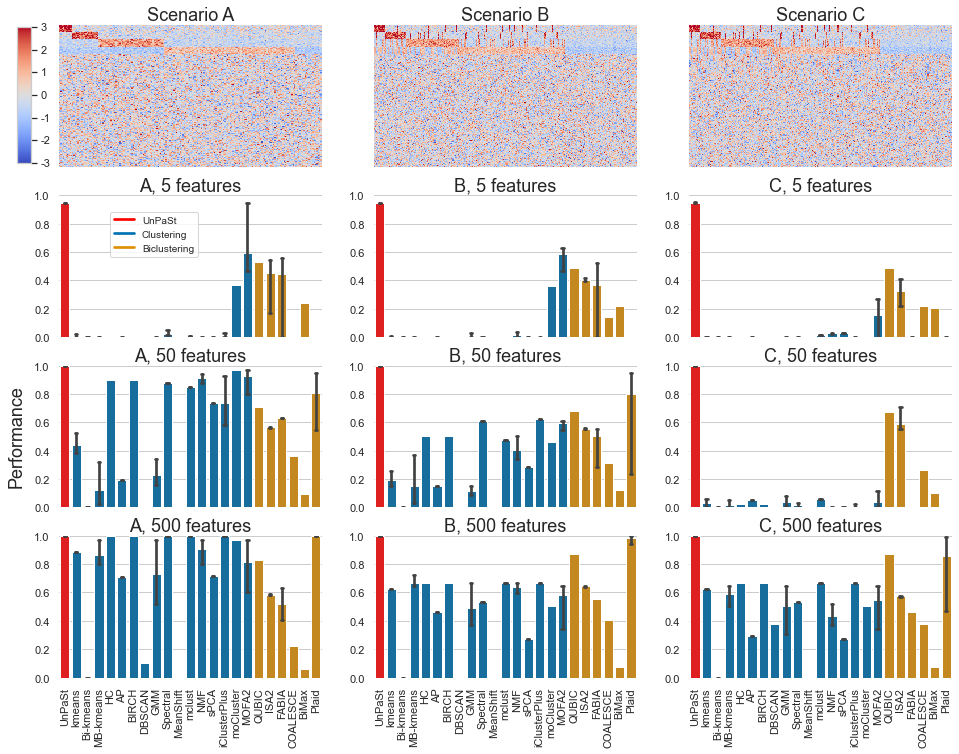

In [6]:
# prepare simulated data for plots
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from utils.eval import generate_exprs
from utils.method import zscore
import settings

import matplotlib.cm as cm

##### create heatmap legend and save to load later as image
# Create a figure and axis
fig, ax = plt.subplots(figsize=(.25, 2.5))

# from -3 to 3
# Create a ScalarMappable object for the colorbar
sm = cm.ScalarMappable(cmap='coolwarm')
# Set the range of values for the colorbar
sm.set_array([])
sm.set_clim(vmin=-3, vmax=3)

# Add the colorbar to the plot
colorbar = plt.colorbar(sm, cax=ax)
colorbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
colorbar.set_ticklabels([-3, -2, -1, 0, 1, 2, 3])
# Set a label for the colorbar
colorbar.set_label('')

plt.savefig('legend_heatmap.png', bbox_inches='tight')
plt.clf()



# one additional row for the simulated data heatmap
fig, axs = plt.subplots(nrows=len(settings.SCENARIOS) + 1, ncols=len(settings.GENE_SIZES), sharex=False, sharey=False, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 2, 2, 2]})

legend_heatmap = plt.imread('legend_heatmap.png')
# legend_heatmap.resize((200,10))
axs[0, 0].figure.figimage(legend_heatmap, 10, 578, alpha=1)

# background expressions N(0,1)
seed = 42
# dimensions of the matrix
n_genes = 10000 # genes 
N = 200  # samples

# bicluster expression parameters
m = 4
std = 1

# fractions of samples included to each subtype
frac_samples= [0.05, 0.1, 0.25, 0.5]

# number of biomarkers for each subtype
n_biomarkers = 500

# add 4 co-expression modules of 50 genes each, with avg. r=0.5 
add_coexpressed = [500]*4 

##### HEATMAP C
exprs, ground_truth,coexpressed_modules = generate_exprs((n_genes,N),
                                                         g_size=n_biomarkers,
                                                         frac_samples=frac_samples,
                                                         m=m,std=std,
                                                         #outdir = False,outfile_basename=False, 
                                                         g_overlap=False,s_overlap=True,
                                                         seed = seed, 
                                                         add_coexpressed = add_coexpressed)
bic_g = []
bic_s = []
for row in ground_truth.iterrows():
    bic = row[1]
    g = list(bic["genes"])
    s = list(bic["samples"])
    bic_g += g
    bic_s += s
for module in coexpressed_modules:
    bic_g +=  [x for x in module if not x in bic_g]
    
bg_g = set(exprs.index.values).difference(set(bic_g))
bg_s = set(exprs.columns.values).difference(set(bic_s))

samples = bic_s + list(bg_s)
genes = bic_g + list(bg_g)

exprs = zscore(exprs)
cg = sns.heatmap(exprs.loc[bic_g+sorted(bg_g),bic_s+sorted(bg_s)],
                    xticklabels=False,yticklabels=False, cbar=False,
                    cmap=sns.color_palette("coolwarm", as_cmap=True),vmin=-3,vmax=3, ax=axs[0, 2])

axs[0, 2].set_title('Scenario C', fontsize=18, y=1.0, pad=5) # pad=-8
# sub_fig.set(xlabel=None, ylabel=None)
sns.despine(bottom = True, left = True, right=True, top=True)

##### HEATMAP B
exprs, ground_truth,coexpressed_modules = generate_exprs((n_genes,N),
                                                         g_size=n_biomarkers,
                                                         frac_samples=frac_samples,
                                                         m=m,std=std,
                                                         #outdir = False,outfile_basename=False, 
                                                         g_overlap=False,s_overlap=True,
                                                         seed = seed, 
                                                         #add_coexpressed = add_coexpressed
                                                        )

bic_g = []
bic_s = []
for row in ground_truth.iterrows():
    bic = row[1]
    g = list(bic["genes"])
    s = list(bic["samples"])
    bic_g += g
    bic_s += s
    
bg_g = set(exprs.index.values).difference(set(bic_g))
bg_s = set(exprs.columns.values).difference(set(bic_s))

samples = bic_s + list(bg_s)
genes = bic_g + list(bg_g)

exprs = zscore(exprs)
cg = sns.heatmap(exprs.loc[bic_g+sorted(bg_g),bic_s+sorted(bg_s)],
                    xticklabels=False, yticklabels=False, cbar=False,
                    cmap=sns.color_palette("coolwarm", as_cmap=True),vmin=-3,vmax=3, ax=axs[0, 1])
axs[0, 1].set_title('Scenario B', fontsize=18, y=1.0, pad=5) # pad=-8
# sub_fig.set(xlabel=None, ylabel=None)
sns.despine(bottom = True, left = True, right=True, top=True)

##### HEATMAP A
exprs, ground_truth,coexpressed_modules = generate_exprs((n_genes,N),
                                                         g_size=n_biomarkers,
                                                         frac_samples=frac_samples,
                                                         m=m,std=std,
                                                         #outdir = False,outfile_basename=False, 
                                                         g_overlap=False,s_overlap=False,
                                                         seed = seed, 
                                                         #add_coexpressed = add_coexpressed,
                                                        )

bic_g = []
bic_s = []
for row in ground_truth.iterrows():
    bic = row[1]
    g = list(bic["genes"])
    s = list(bic["samples"])
    bic_g += g
    bic_s += s
    
bg_g = set(exprs.index.values).difference(set(bic_g))
bg_s = set(exprs.columns.values).difference(set(bic_s))

samples = bic_s + list(bg_s)
genes = bic_g + list(bg_g)

exprs = zscore(exprs)
cg = sns.heatmap(exprs.loc[bic_g+sorted(bg_g),bic_s+sorted(bg_s)],
                    xticklabels=False,yticklabels=False, cbar=False,
                    cmap=sns.color_palette("coolwarm", as_cmap=True),vmin=-3,vmax=3, ax=axs[0, 0])
axs[0, 0].set_title('Scenario A', fontsize=18, y=1.0, pad=5) # pad=-8
# sub_fig.set(xlabel=None, ylabel=None)
sns.despine(bottom = True, left = True, right=True, top=True)



# plot results

import settings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.patches import Rectangle
import matplotlib
sns.set_theme(style="whitegrid")
%matplotlib inline

def replace_string_in_list(arr, orig, rep):
    index = arr.index(orig)
    assert index > -1
    arr[index] = rep
    return arr

def remove_substring_from_params(x, string, chars_right):
    x = str(x)
    pos = x.find(string)
    if pos > -1:
        return x[:pos] + x[pos + len(string) + chars_right:]
    return x

def calc_average(df):
    df = df.fillna(0)
    return df.groupby(['scenario', 'gsize', 'parameters']).mean().reset_index()

def calc_best_params(df, table_key):
    """Group data by runs and find best parameter combination"""
    # merge runs with different seeds
    if 'run' in df or not df["parameters"].is_unique:
        df = calc_average(df)
    top_params = df.groupby('parameters').mean().reset_index().sort_values(table_key, ascending=False).iloc[0]['parameters']
    return top_params

def get_best_run_values(df, table_key, params, method):
    """Return values for best parameter combination in seaborn format"""
    # all runs are needed for error calculation
    top_values = df[df['parameters']==params][table_key].values
    # formatting as sns input
    df_top = pd.DataFrame(top_values, columns=['value'])
    df_top['method'] = method
    return df_top

### 1 Collect data
scenario_data = {s: {g: pd.DataFrame(columns=['method', 'value']) for g in settings.GENE_SIZES} for s in settings.SCENARIOS}
table_key = 'performance'
found_methods = set()
for method in settings.METHODS:
    file_path = os.path.join(PATH_TO_SIMULATED_RESULTS, f'{method}_ABC.tsv')
    try:
        df = pd.read_csv(file_path, sep='\t')
        if 'simulated' in df.columns and 'performance_simulated' in df.columns:
            del df['simulated']
        df = df.rename(columns={'param': 'parameters', 'simulated': 'performance', 'performance_simulated': 'performance'})
        if 'seed' not in df.columns and 'seeds=' in df.iloc[0]['parameters']:
                # assumes that seeds= is last parameter, grandforest
                df['seed'] = df['parameters'].map(lambda x: x.split('seeds=')[-1])
                df['run'] = df['parameters'].map(lambda x: x.split('seeds=')[-1])
                df['parameters'] = df['parameters'].map(lambda x: x.split('seeds=')[0])
    except:
        print(f'Warning: No file found for {method} on simulated data.')
        continue
    # remember found methods for plot
    found_methods.add(method)
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'random_state=', 1))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/A/5/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/A/50/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/A/500/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/B/5/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/B/50/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/B/500/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/C/5/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/C/50/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/C/500/', 0))

    try:
        top_params = calc_best_params(df, table_key)
        print(method, top_params)
    except Exception as e:
#         print(e)
        continue
    
    for scenario in settings.SCENARIOS:
        for gene_size in settings.GENE_SIZES:
            df_sub = df[(df['scenario']==scenario) & (df['gsize']==gene_size)]
            if len(df_sub):
                df_top = get_best_run_values(df_sub, table_key, top_params, method)
            else:
                df_top = pd.DataFrame([[0, method]], columns=['value', 'method'])
            df_top.loc[df_top['method']=='AffinityPropagation', 'method'] = 'AP'
            df_top.loc[df_top['method']=='AgglomerativeClustering', 'method'] = 'AC'
            print(pd.concat([scenario_data[scenario][gene_size], df_top]))
            scenario_data[scenario][gene_size] = pd.concat([scenario_data[scenario][gene_size], df_top])

### 2 Plot
order = [method for method in settings.METHODS if method in found_methods]
order = [settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x for x in order]
order = [x.replace('_', ' ') for x in order]

for x, scenario in enumerate(settings.SCENARIOS):
    for y, gene_size in enumerate(settings.GENE_SIZES):
        # +1 to leave first row for heatmaps
        ax = axs[y+1, x]
        data = scenario_data[scenario][gene_size]
        data['method'] = data['method'].map(lambda x: settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x)
        data['method'] = data['method'].map(lambda x: x.replace('_', ' '))
        sub_fig = sns.barplot(data=data, y='value', x='method', estimator=np.mean, errorbar=(lambda x: (min(x), max(x))), capsize=.2, ax=ax, order=order, palette=settings.METHOD_PALETTE)
        # sub_fig.legend_.remove()
        ax.set_title(f'{scenario}, {gene_size} features', fontsize=18, y=1.0, pad=5) # pad=-8
        ax.tick_params(axis='x', rotation=90) # 
        ax.set(ylim=(0, 1))
        sub_fig.set(xlabel=None, ylabel=None)
        sns.despine(bottom = True, left = True, right=True, top=True)
        
        if gene_size != 500:
            ax.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
        
# fig.subplots_adjust(hspace=1)
# fig.suptitle('Method comparison on simulated data (overall best parameters)', fontsize=20, y=.95)

#legend
# plt.legend(handles=[cg], loc='lower right')


fig.text(0.08, 0.405, 'Performance', va='center', rotation='vertical', fontsize=18)
leg = fig.legend(settings.METHOD_TYPE_PALETTE, title="",fontsize='medium', fancybox=True, loc=1, bbox_to_anchor=(0.25, .67)) # 0.905, .71
for i, (key, color) in enumerate(settings.METHOD_TYPE_PALETTE.items()):
    leg.legendHandles[i].set_color(color)
    
# fig.text(-0.02, 0.355, 'Jaccard index', va='center', rotation='vertical', fontsize=18)
# plt.savefig('paper/Figure3.png', dpi=300)

# NOTE: heatmap is not saved properly 


# Figure S3

UnPaSt bin=kmeans;pval=0.01;direction=UP-DOWN;clust=WGCNA;dch=0.995;ds=3;preClustering=T
kmeans k=5;max_iter=300;init=k-means++;tol=0.0001
BisectingKMeans k=5;max_iter=300;tol=0.0001;bisecting_strategy=biggest_inertia
MiniBatchKMeans k=5;max_iter=300;batch_size=1024;max_no_improvement=10;reassignment_ratio=0.01
HierarchicalClustering k=5;linkage=ward
AffinityPropagation damping=0.55;max_iter=200
BIRCH k=5;branching_factor=50;threshold=0.5
DBSCAN eps=0.5;min_samples=5
GMM covtype=full;initmethod=kmeans;k=5
SpectralClustering k=5;n_neighbors=10;assign_labels=kmeans;n_inits=10
MeanShift max_iters=300;cluster_all=True;min_bin_freq=1
Could not find default parameters for mclust
NMF k=5;init=nndsvda;tol=0.0001;;transposed=False;alpha_W=-0.1;alpha_H=0.0;shuffle=False;solver=cd;beta_loss=frobenius;max_iter=200;
sparse_PCA n_components=5;;alpha=1;ridge_alpha=0.01;max_iter=1000;method=cd;tol=1e-08;
iClusterPlus lambda_n=null;n_cluster=5;lambda_scale=1;iter_max=20;eps=0.0001;;type=gaussian;burnin

/var/folders/k5/qbs_42rd35j4mmpzqs47hdrw0000gn/T/ipykernel_38792/590141262.py:200: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[i].set_color(color)


<Figure size 18x180 with 0 Axes>

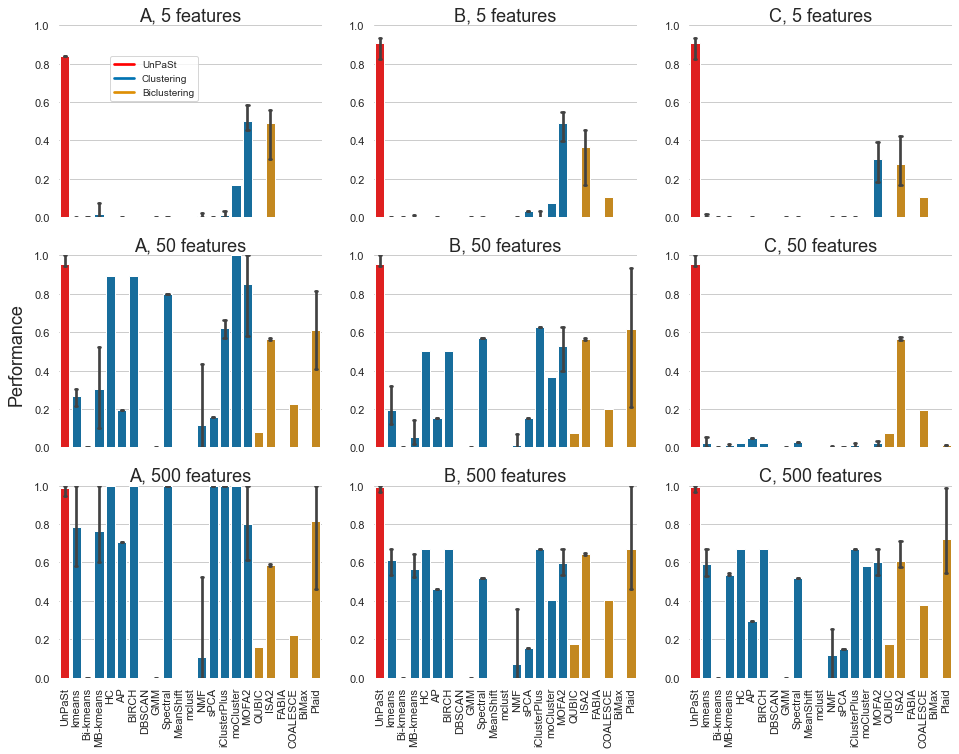

In [7]:
# prepare simulated data for plots
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from utils.eval import generate_exprs
from utils.method import zscore
import settings
import copy
import matplotlib.cm as cm

##### create heatmap legend and save to load later as image
# Create a figure and axis
fig, ax = plt.subplots(figsize=(.25, 2.5))

# fro -3 to 3
# Create a ScalarMappable object for the colorbar
sm = cm.ScalarMappable(cmap='coolwarm')
# Set the range of values for the colorbar
sm.set_array([])
sm.set_clim(vmin=-3, vmax=3)

# Add the colorbar to the plot
colorbar = plt.colorbar(sm, cax=ax)
colorbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
colorbar.set_ticklabels([-3, -2, -1, 0, 1, 2, 3])
# Set a label for the colorbar
colorbar.set_label('')

plt.savefig('legend_heatmap.png', bbox_inches='tight')
plt.clf()



# one additional row for the simulated data heatmap
fig, axs = plt.subplots(nrows=len(settings.SCENARIOS), ncols=len(settings.GENE_SIZES), sharex=False, sharey=False, figsize=(16, 12), gridspec_kw={'height_ratios': [ 2, 2, 2]})

# plot results

import settings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.patches import Rectangle
import matplotlib
sns.set_theme(style="whitegrid")
%matplotlib inline

def replace_string_in_list(arr, orig, rep):
    index = arr.index(orig)
    assert index > -1
    arr[index] = rep
    return arr


def calc_best_params(df, table_key):
    """Group data by runs and find best parameter combination"""
    # merge runs with different seeds
    if 'run' in df or not df["parameters"].is_unique:
        df = calc_average(df)
    top_params = df.groupby('parameters').mean().reset_index().sort_values(table_key, ascending=False).iloc[0]['parameters']
    return top_params

def get_best_run_values(df, table_key, params, method):
    """Return values for best parameter combination in seaborn format"""
    # all runs are needed for error calculation
    top_values = df[df['parameters']==params][table_key].values
    # formatting as sns input
    df_top = pd.DataFrame(top_values, columns=['value'])
    df_top['method'] = method
    return df_top

def calc_average(df):
    df = df.fillna(0)
    return df.groupby(['scenario', 'gsize', 'parameters']).mean().reset_index()

def find_default_params(df, table_key, method):
    """Group data by runs and find best parameter combination"""
    # merge runs with different seeds
    default_params = settings.DEFAULT_PARAMETERS[method]
    for i, row in df.iterrows():
        mode = True
        for key, value in default_params.items():
            substring = f'{key}={value}'
            if substring in row['parameters']:
                continue
            mode = False
        if mode is True:
            break
    if mode is False:
        print('Could not find default parameters for', method)
        raise Exception
    return row['parameters']

def get_default_run_values(df, table_key, params, method):
    """Return values for best parameter combination in seaborn format"""
    # all runs are needed for error calculation
    top_values = df[df['parameters']==params][table_key].values
    # formatting as sns input
    df_top = pd.DataFrame(top_values, columns=['value'])
    df_top['method'] = method
    return df_top

### 1 Collect data
scenario_data = {s: {g: pd.DataFrame(columns=['method', 'value']) for g in settings.GENE_SIZES} for s in settings.SCENARIOS}
table_key = 'performance'
found_methods = set()
for method in settings.METHODS:
    file_path = os.path.join(PATH_TO_SIMULATED_RESULTS, f'{method}_ABC.tsv')
    try:
        df = pd.read_csv(file_path, sep='\t')
        if 'simulated' in df.columns and 'performance_simulated' in df.columns:
            del df['simulated']
        df = df.rename(columns={'param': 'parameters', 'simulated': 'performance', 'performance_simulated': 'performance'})
        if 'seed' not in df.columns and 'seeds=' in df.iloc[0]['parameters']:
                # assumes that seeds= is last parameter, grandforest
                df['seed'] = df['parameters'].map(lambda x: x.split('seeds=')[-1])
                df['run'] = df['parameters'].map(lambda x: x.split('seeds=')[-1])
                df['parameters'] = df['parameters'].map(lambda x: x.split('seeds=')[0])
    except:
        print(f'Warning: No file found for {method} on simulated data.')
        continue
    # remember found methods for plot
    found_methods.add(method)
    
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'random_state=', 1))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/A/5/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/A/50/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/A/500/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/B/5/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/B/50/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/B/500/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/C/5/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/C/50/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/C/500/', 0))

    try:
        default_params = find_default_params(df, table_key, method)
        print(method, default_params)
    except Exception as e:
#         print('Exception:', method,  e)
        continue
    for scenario in settings.SCENARIOS:
        for gene_size in settings.GENE_SIZES:
            df_sub = df[(df['scenario']==scenario) & (df['gsize']==gene_size)]
            if len(df_sub):
                df_top = get_default_run_values(df_sub, table_key, default_params, method)
            else:
                df_top = pd.DataFrame([[0, method]], columns=['value', 'method'])
                
            df_top.loc[df_top['method']=='AffinityPropagation', 'method'] = 'AP'
            df_top.loc[df_top['method']=='AgglomerativeClustering', 'method'] = 'AC'
            scenario_data[scenario][gene_size] = pd.concat([scenario_data[scenario][gene_size], df_top])

### 2 Plot
order = [method for method in settings.METHODS if method in found_methods]
order = [settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x for x in order]
order = [x.replace('_', ' ') for x in order]

# order = [x for x in order if x != 'UnPaSt']

for x, scenario in enumerate(settings.SCENARIOS):
    for y, gene_size in enumerate(settings.GENE_SIZES):
        # +1 to leave first row for heatmaps
        ax = axs[y, x]
        data = scenario_data[scenario][gene_size]
        data['method'] = data['method'].map(lambda x: settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x)
        data['method'] = data['method'].map(lambda x: x.replace('_', ' '))
        sub_fig = sns.barplot(data=data, y='value', x='method', estimator=np.mean, errorbar=(lambda x: (min(x), max(x))), capsize=.2, ax=ax, order=order, palette=settings.METHOD_PALETTE)
        # sub_fig.legend_.remove()
        ax.set_title(f'{scenario}, {gene_size} features', fontsize=18, y=1.0, pad=5) # pad=-8
        ax.tick_params(axis='x', rotation=90) # 
        ax.set(ylim=(0, 1))
        sub_fig.set(xlabel=None, ylabel=None)
        sns.despine(bottom = True, left = True, right=True, top=True)
        
        if gene_size != 500:
            ax.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
        
# fig.subplots_adjust(hspace=1)
# fig.suptitle('Method comparison on simulated data (overall best parameters)', fontsize=20, y=.95)

#legend
# plt.legend(handles=[cg], loc='lower right')

palette = copy.deepcopy(settings.METHOD_TYPE_PALETTE)
# del palette['UnPaSt']

fig.text(0.08, 0.5, 'Performance', va='center', rotation='vertical', fontsize=18)
leg = fig.legend(palette, title="",fontsize='medium', fancybox=True, loc=1, bbox_to_anchor=(0.25, .85)) # 0.905, .71
for i, (key, color) in enumerate(palette.items()):
    leg.legendHandles[i].set_color(color)

sns.despine(bottom = True, left = True, right=True, top=True)
    
# fig.text(-0.02, 0.355, 'Jaccard index', va='center', rotation='vertical', fontsize=18)
plt.savefig('paper/supplement/FigureS3.png', dpi=300,bbox_inches='tight')

# Figure S4 performance gain after parameter tuning simulated dataset

UnPaSt bin=GMM;pval=0.05;direction=UP-DOWN;clust=WGCNA;dch=0.995;ds=0;preClustering=T
UnPaSt bin=kmeans;pval=0.01;direction=UP-DOWN;clust=WGCNA;dch=0.995;ds=3;preClustering=T
kmeans k=3;max_iter=1000;init=k-means++;tol=0.0001
kmeans k=5;max_iter=300;init=k-means++;tol=0.0001
BisectingKMeans k=10;max_iter=300;tol=0.0001;bisecting_strategy=biggest_inertia
BisectingKMeans k=5;max_iter=300;tol=0.0001;bisecting_strategy=biggest_inertia
MiniBatchKMeans k=4;max_iter=300;batch_size=1024;max_no_improvement=10;reassignment_ratio=0.01
MiniBatchKMeans k=5;max_iter=300;batch_size=1024;max_no_improvement=10;reassignment_ratio=0.01
HierarchicalClustering k=5;linkage=ward
HierarchicalClustering k=5;linkage=ward
AffinityPropagation damping=0.9;max_iter=200
AffinityPropagation damping=0.55;max_iter=200
BIRCH k=5;branching_factor=100;threshold=0.5
BIRCH k=5;branching_factor=50;threshold=0.5
DBSCAN eps=130;min_samples=3
DBSCAN eps=0.5;min_samples=5
GMM covtype=diag;initmethod=kmeans;k=5
GMM covtype=full;i

/var/folders/k5/qbs_42rd35j4mmpzqs47hdrw0000gn/T/ipykernel_38792/569852798.py:211: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[i].set_color(color)


<Figure size 18x180 with 0 Axes>

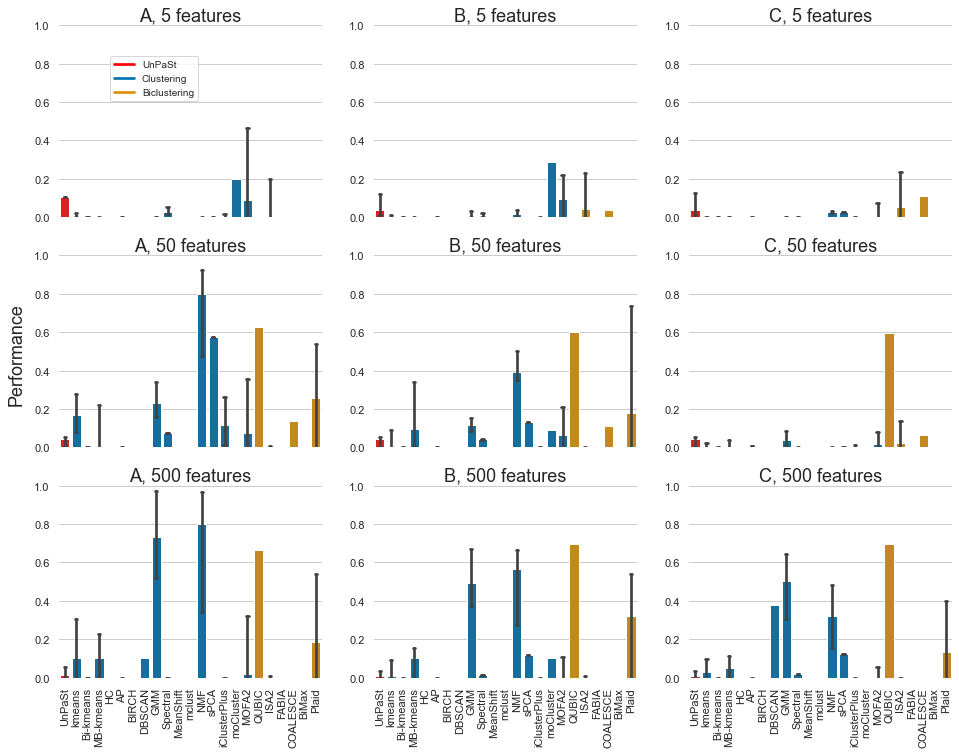

In [8]:
# prepare simulated data for plots
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from utils.eval import generate_exprs
from utils.method import zscore
import settings
import copy
import matplotlib.cm as cm

##### create heatmap legend and save to load later as image
# Create a figure and axis
fig, ax = plt.subplots(figsize=(.25, 2.5))

# fro -3 to 3
# Create a ScalarMappable object for the colorbar
sm = cm.ScalarMappable(cmap='coolwarm')
# Set the range of values for the colorbar
sm.set_array([])
sm.set_clim(vmin=-3, vmax=3)

# Add the colorbar to the plot
colorbar = plt.colorbar(sm, cax=ax)
colorbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
colorbar.set_ticklabels([-3, -2, -1, 0, 1, 2, 3])
# Set a label for the colorbar
colorbar.set_label('')

plt.savefig('legend_heatmap.png', bbox_inches='tight')
plt.clf()



# one additional row for the simulated data heatmap
fig, axs = plt.subplots(nrows=len(settings.SCENARIOS), ncols=len(settings.GENE_SIZES), sharex=False, sharey=False, figsize=(16, 12), gridspec_kw={'height_ratios': [ 2, 2, 2]})

# plot results

import settings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.patches import Rectangle
import matplotlib
sns.set_theme(style="whitegrid")
%matplotlib inline

def replace_string_in_list(arr, orig, rep):
    index = arr.index(orig)
    assert index > -1
    arr[index] = rep
    return arr


def calc_best_params(df, table_key):
    """Group data by runs and find best parameter combination"""
    # merge runs with different seeds
    if 'run' in df or not df["parameters"].is_unique:
        df = calc_average(df)
    top_params = df.groupby('parameters').mean().reset_index().sort_values(table_key, ascending=False).iloc[0]['parameters']
    return top_params

def get_best_run_values(df, table_key, params, method):
    """Return values for best parameter combination in seaborn format"""
    # all runs are needed for error calculation
    top_values = df[df['parameters']==params][table_key].values
    # formatting as sns input
    df_top = pd.DataFrame(top_values, columns=['value'])
    df_top['method'] = method
    return df_top

def calc_average(df):
    df = df.fillna(0)
    return df.groupby(['scenario', 'gsize', 'parameters']).mean().reset_index()

def find_default_params(df, table_key, method):
    """Group data by runs and find best parameter combination"""
    # merge runs with different seeds
    default_params = settings.DEFAULT_PARAMETERS[method]
    for i, row in df.iterrows():
        mode = True
        for key, value in default_params.items():
            substring = f'{key}={value}'
            if substring in row['parameters']:
                continue
            mode = False
        if mode is True:
            break
    if mode is False:
        print('Could not find default parameters for', method)
        raise Exception
    return row['parameters']

def get_default_run_values(df, table_key, params, method):
    """Return values for best parameter combination in seaborn format"""
    # all runs are needed for error calculation
    top_values = df[df['parameters']==params][table_key].values
    # formatting as sns input
    df_top = pd.DataFrame(top_values, columns=['value'])
    df_top['method'] = method
    return df_top

### 1 Collect data
scenario_data = {s: {g: pd.DataFrame(columns=['method', 'value']) for g in settings.GENE_SIZES} for s in settings.SCENARIOS}
table_key = 'performance'
found_methods = set()
for method in settings.METHODS:
    file_path = os.path.join(PATH_TO_SIMULATED_RESULTS, f'{method}_ABC.tsv')
    try:
        df = pd.read_csv(file_path, sep='\t')
        if 'simulated' in df.columns and 'performance_simulated' in df.columns:
            del df['simulated']
        df = df.rename(columns={'param': 'parameters', 'simulated': 'performance', 'performance_simulated': 'performance'})
        if 'seed' not in df.columns and 'seeds=' in df.iloc[0]['parameters']:
                # assumes that seeds= is last parameter, grandforest
                df['seed'] = df['parameters'].map(lambda x: x.split('seeds=')[-1])
                df['run'] = df['parameters'].map(lambda x: x.split('seeds=')[-1])
                df['parameters'] = df['parameters'].map(lambda x: x.split('seeds=')[0])
    except:
        print(f'Warning: No file found for {method} on simulated data.')
        continue
    # remember found methods for plot
    found_methods.add(method)
    
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'random_state=', 1))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/A/5/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/A/50/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/A/500/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/B/5/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/B/50/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/B/500/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/C/5/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/C/50/', 0))
    df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, '/C/500/', 0))

    try:
        top_params = calc_best_params(df, table_key)
        print(method, top_params)
    except Exception as e:
#         print(e)
        continue
    
    try:
        default_params = find_default_params(df, table_key, method)
        print(method, default_params)
    except Exception as e:
#         print('Exception:', method,  e)
        continue
    for scenario in settings.SCENARIOS:
        for gene_size in settings.GENE_SIZES:
            df_sub = df[(df['scenario']==scenario) & (df['gsize']==gene_size)]
            if len(df_sub):
                df_top = get_default_run_values(df_sub, table_key, default_params, method)
                df_top_best = get_best_run_values(df_sub, table_key, top_params, method)
            else:
                df_top = pd.DataFrame([[0, method]], columns=['value', 'method'])
                df_top_best = pd.DataFrame([[0, method]], columns=['value', 'method'])
                
            df_top['value'] = df_top_best['value'] - df_top['value']
                
            df_top.loc[df_top['method']=='AffinityPropagation', 'method'] = 'AP'
            df_top.loc[df_top['method']=='AgglomerativeClustering', 'method'] = 'AC'
            scenario_data[scenario][gene_size] = pd.concat([scenario_data[scenario][gene_size], df_top])

### 2 Plot
order = [method for method in settings.METHODS if method in found_methods]
order = [settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x for x in order]
order = [x.replace('_', ' ') for x in order]

# order = [x for x in order if x != 'UnPaSt']

for x, scenario in enumerate(settings.SCENARIOS):
    for y, gene_size in enumerate(settings.GENE_SIZES):
        # +1 to leave first row for heatmaps
        ax = axs[y, x]
        data = scenario_data[scenario][gene_size]
        data['method'] = data['method'].map(lambda x: settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x)
        data['method'] = data['method'].map(lambda x: x.replace('_', ' '))
        sub_fig = sns.barplot(data=data, y='value', x='method', estimator=np.mean, errorbar=(lambda x: (min(x), max(x))), capsize=.2, ax=ax, order=order, palette=settings.METHOD_PALETTE)
        # sub_fig.legend_.remove()
        ax.set_title(f'{scenario}, {gene_size} features', fontsize=18, y=1.0, pad=5) # pad=-8
        ax.tick_params(axis='x', rotation=90) # 
        ax.set(ylim=(0, 1))
        sub_fig.set(xlabel=None, ylabel=None)
        sns.despine(bottom = True, left = True, right=True, top=True)
        
        if gene_size != 500:
            ax.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
        
# fig.subplots_adjust(hspace=1)
# fig.suptitle('Method comparison on simulated data (overall best parameters)', fontsize=20, y=.95)

#legend
# plt.legend(handles=[cg], loc='lower right')

palette = copy.deepcopy(settings.METHOD_TYPE_PALETTE)
# del palette['UnPaSt']

fig.text(0.08, 0.5, 'Performance', va='center', rotation='vertical', fontsize=18)
leg = fig.legend(palette, title="",fontsize='medium', fancybox=True, loc=1, bbox_to_anchor=(0.25, .85)) # 0.905, .71
for i, (key, color) in enumerate(palette.items()):
    leg.legendHandles[i].set_color(color)

sns.despine(bottom = True, left = True, right=True, top=True)
    
# fig.text(-0.02, 0.355, 'Jaccard index', va='center', rotation='vertical', fontsize=18)
plt.savefig('paper/supplement/FigureS4.png', dpi=300,bbox_inches='tight')

# Figure 4 A: BRCA performance with parameters tuned on TCGA

/var/folders/k5/qbs_42rd35j4mmpzqs47hdrw0000gn/T/ipykernel_38792/1422232161.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for bars, hatch, legend_handle in zip(sub_fig.containers, ['', '//'], sub_fig.legend_.legendHandles):
/var/folders/k5/qbs_42rd35j4mmpzqs47hdrw0000gn/T/ipykernel_38792/1422232161.py:190: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for bars, hatch, legend_handle in zip(sub_fig.containers, ['', '//'], sub_fig.legend_.legendHandles):


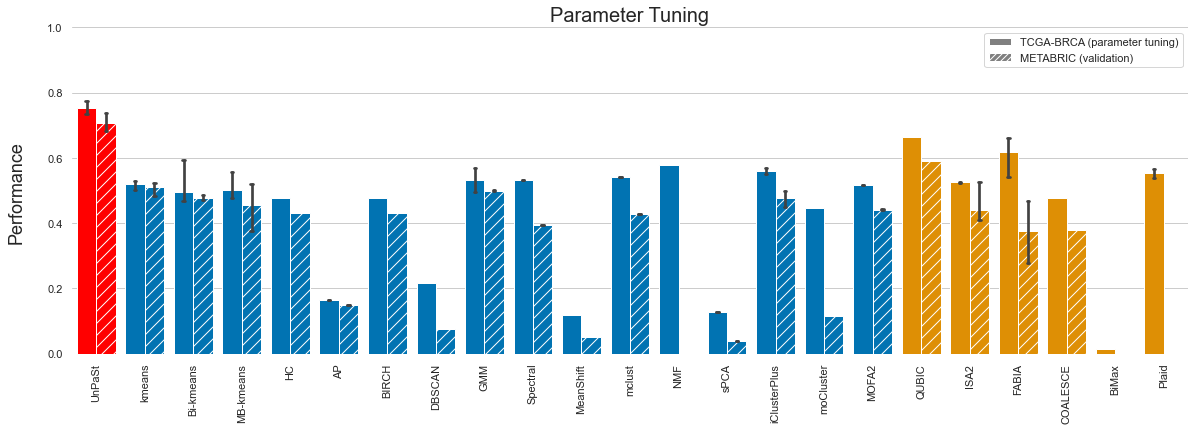

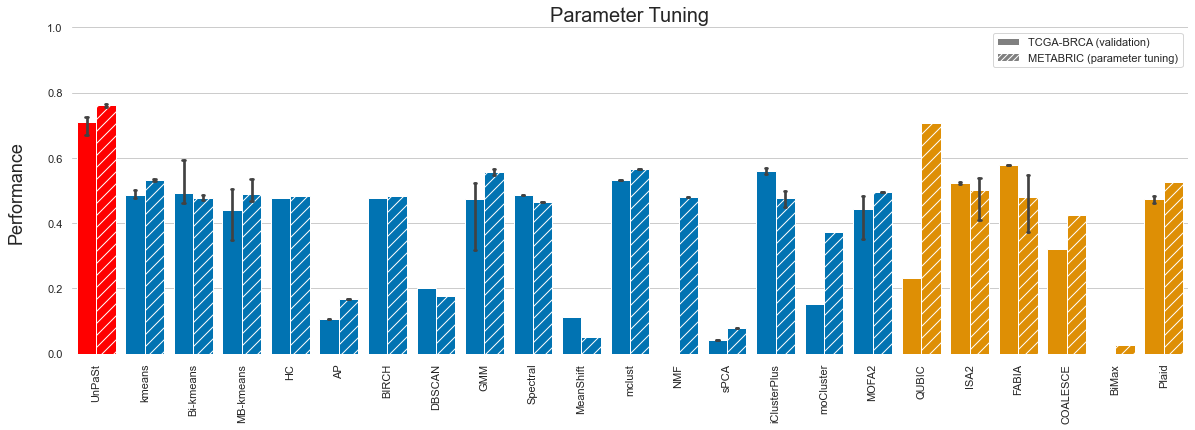

In [18]:
import settings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.patches import Rectangle
import matplotlib
from itertools import cycle

sns.set_theme(style="whitegrid")

%matplotlib inline

cancer_types = []
for _, values in settings.CANCER_GROUPS:
    cancer_types.extend(values)




def remove_substring_from_params(x, string, chars_right):
    pos = x.find(string)
    if pos > -1:
        return x[:pos] + x[pos + len(string) + chars_right:]
    return x

table_key='PAM50'

### 1 Collect data
data = {dataset: {d: pd.DataFrame() for d in settings.REAL_DATASETS} for dataset in settings.REAL_DATASETS}
        
found_methods = set()
for dataset in settings.REAL_DATASETS:
    for method in settings.METHODS:
        try:
            df = pd.DataFrame()
            for _dataset in settings.REAL_DATASETS:
                file_path = os.path.join(PATH_TO_REAL_RESULTS, f'{method}_{_dataset}.tsv')
                df_cur = pd.read_csv(file_path, sep='\t')
                df_cur = df_cur.rename(columns={'param': 'parameters'})
                if 'seed' not in df_cur.columns and 'seeds=' in df_cur.iloc[0]['parameters']:
                    # assumes that seeds= is last parameter, grandforest
                    df_cur['seed'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[-1])
                    df_cur['run'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[-1])
                    df_cur['parameters'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[0])

                df_cur = df_cur.dropna(axis=0, subset=['parameters'])
                df_cur['dataset'] = _dataset
                df = pd.concat([df, df_cur])
        except:
            print(f'Warning: No file found for {method} on real data.')
            continue
        found_methods.add(method)
        # merge runs with different seeds
        if 'run' in df or not df["parameters"].is_unique:
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'random_state=', 1))
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'TCGA', 0))
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'METABRIC', 0))
        
        other_dataset = 'TCGA' if dataset == 'METABRIC' else 'METABRIC'
        
        top_params = best_params[dataset][method]
        df_top_values = df[df['parameters']==top_params]
        df_top_values = clean_columns(df_top_values)
        # limit to used cancer types
        df_top_values = df_top_values[[table_key, 'dataset']]
        # format for sns input
        df_top_values_sub = df_top_values[df_top_values['dataset']==dataset]
        del df_top_values_sub['dataset']
        df_top_values_sub = df_top_values_sub.melt()
        df_top_values_sub['Method'] = method
        df_top_values_sub = df_top_values_sub.rename(columns={'value': 'Jaccard index', 'variable': 'Cancer type'})
        data[dataset][dataset] = pd.concat([data[dataset][dataset], df_top_values_sub])
        
#         top_params = best_params[other_dataset][method]
        df_top_values = df[df['parameters']==top_params]
        df_top_values = clean_columns(df_top_values)
        # limit to used cancer types
        df_top_values = df_top_values[[table_key, 'dataset']]
        # format for sns input
        df_top_values_sub = df_top_values[df_top_values['dataset']==other_dataset]
        del df_top_values_sub['dataset']
        df_top_values_sub = df_top_values_sub.melt()
        df_top_values_sub['Method'] = method
        df_top_values_sub = df_top_values_sub.rename(columns={'value': 'Jaccard index', 'variable': 'Cancer type'})
        data[dataset][other_dataset] = pd.concat([data[dataset][other_dataset], df_top_values_sub])


order = [method for method in settings.METHODS if method in found_methods]
order = [settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x for x in order]
order = [x.replace('_', ' ') for x in order]

### 2 Plot w/o network constraint methods
datasets = ['TCGA']
fig, axs = plt.subplots(len(datasets), 1, sharex=False, sharey=True, figsize=(20, 6))
for i, dataset in enumerate(datasets):
    other_dataset = 'TCGA' if dataset == 'METABRIC' else 'METABRIC'
    plt.subplots_adjust(hspace=0.6)
    sub_df = data[dataset][dataset].copy()
    sub_df['Dataset'] = dataset
    sub_df_other = data[dataset][other_dataset].copy()
    sub_df_other['Dataset'] = other_dataset
    sub_df = pd.concat([sub_df, sub_df_other])
    
    # remove network constraint methods
    sub_df = sub_df[~sub_df['Method'].isin(settings.METHODS_NETWORK_CONSTRAINT)]
    _order = [x for x in order if x not in settings.METHODS_NETWORK_CONSTRAINT]
    
    sub_df['Method'] = sub_df['Method'].map(lambda x: settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x)
    sub_df['Method'] = sub_df['Method'].map(lambda x: x.replace('_', ' '))
    sub_df['Jaccard index'] = pd.to_numeric(sub_df['Jaccard index'])
    
        
    #  rename dataset to 'TCGA-BRCA' if label is 'TCGA'
    sub_df['Dataset'] = sub_df['Dataset'].map(lambda x: 'TCGA-BRCA' if x == 'TCGA' else x)
    
    palette=['grey', 'grey']
    sub_fig = sns.barplot(palette=palette, hue_order=['TCGA-BRCA', 'METABRIC'], data=sub_df, x='Method',  y='Jaccard index', hue='Dataset', ax=axs, estimator=np.mean, errorbar=(lambda x: (min(x), max(x))), capsize=.05, order=_order) #palette=settings.METHOD_PALETTE
    plt.legend(loc='upper right')
    axs.tick_params(axis='x', rotation=90)
    axs.set(ylim=(0, 1))
    axs.set_title("Parameter Tuning", fontsize=20)
    
    handles, labels = axs.get_legend_handles_labels()
    labels_map = {
        "TCGA-BRCA": "TCGA-BRCA (parameter tuning)",
        "METABRIC": "METABRIC (validation)"
        }
    labels = [labels_map.get(lab, lab) for lab in labels]
    axs.legend(handles, labels, loc='upper right')

    palette = [settings.METHOD_PALETTE[x] for x in _order if x in settings.METHOD_PALETTE]
    for bars, hatch, legend_handle in zip(sub_fig.containers, ['', '//'], sub_fig.legend_.legendHandles):
        for bar, color in zip(bars, palette):
            bar.set_facecolor(color)
            bar.set_hatch(hatch)
        # update the existing legend, use twice the hatching pattern to make it denser
        legend_handle.set_hatch(hatch + hatch)
        
    
    sns.despine(bottom = True, left = True, right=True, top=True)
    sub_fig.set(xlabel=None, ylabel=None)

    fig.text(0.08, 0.5, 'Performance', va='center', rotation='vertical', fontsize=18)
    fig.subplots_adjust(hspace=.5)

plt.savefig(f'paper/supplement/FigureS5_A_TCGA.png', dpi=300,bbox_inches='tight')

### 2 Plot w/o network constraint methods
datasets = ['METABRIC']
fig, axs = plt.subplots(len(datasets), 1, sharex=False, sharey=True, figsize=(20, 6))
for i, dataset in enumerate(datasets):
    other_dataset = 'TCGA' if dataset == 'METABRIC' else 'METABRIC'
    plt.subplots_adjust(hspace=0.6)
    sub_df = data[dataset][dataset].copy()
    sub_df['Dataset'] = dataset
    sub_df_other = data[dataset][other_dataset].copy()
    sub_df_other['Dataset'] = other_dataset
    sub_df = pd.concat([sub_df, sub_df_other])
    
    # remove network constraint methods
    sub_df = sub_df[~sub_df['Method'].isin(settings.METHODS_NETWORK_CONSTRAINT)]
    _order = [x for x in order if x not in settings.METHODS_NETWORK_CONSTRAINT]
    
    sub_df['Method'] = sub_df['Method'].map(lambda x: settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x)
    sub_df['Method'] = sub_df['Method'].map(lambda x: x.replace('_', ' '))
    sub_df['Jaccard index'] = pd.to_numeric(sub_df['Jaccard index'])
    
    #  rename dataset to 'TCGA-BRCA' if label is 'TCGA'
    sub_df['Dataset'] = sub_df['Dataset'].map(lambda x: 'TCGA-BRCA' if x == 'TCGA' else x)
    
    palette=['grey', 'grey']
    sub_fig = sns.barplot(palette=palette, hue_order=['TCGA-BRCA', 'METABRIC'], data=sub_df, x='Method',  y='Jaccard index', hue='Dataset', ax=axs, estimator=np.mean, errorbar=(lambda x: (min(x), max(x))), capsize=.05, order=_order) #palette=settings.METHOD_PALETTE
    plt.legend(loc='upper right')
    axs.tick_params(axis='x', rotation=90)
    axs.set(ylim=(0, 1))
    axs.set_title("Parameter Tuning", fontsize=20)

    
    handles, labels = axs.get_legend_handles_labels()
    labels_map = {
        "TCGA-BRCA": "TCGA-BRCA (validation)",
        "METABRIC": "METABRIC (parameter tuning)"
        }
    labels = [labels_map.get(lab, lab) for lab in labels]
    axs.legend(handles, labels, loc='upper right')
    
    palette = [settings.METHOD_PALETTE[x] for x in _order if x in settings.METHOD_PALETTE]
    for bars, hatch, legend_handle in zip(sub_fig.containers, ['', '//'], sub_fig.legend_.legendHandles):
        for bar, color in zip(bars, palette):
            bar.set_facecolor(color)
            bar.set_hatch(hatch)
        # update the existing legend, use twice the hatching pattern to make it denser
        legend_handle.set_hatch(hatch + hatch)
        

        
    
    sns.despine(bottom = True, left = True, right=True, top=True)
    sub_fig.set(xlabel=None, ylabel=None)

    fig.text(0.08, 0.5, 'Performance', va='center', rotation='vertical', fontsize=18)
    fig.subplots_adjust(hspace=.5)
    
    
plt.savefig(f'paper/supplement/FigureS5_B_METABRIC.png', dpi=300,bbox_inches='tight')

# Figure S4 A: BRCA performance with optimized parameters (on TCGA & METABRIC; min rank sum)

/var/folders/k5/qbs_42rd35j4mmpzqs47hdrw0000gn/T/ipykernel_38792/1343371693.py:113: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for bars, hatch, legend_handle in zip(sub_fig.containers, ['', '//'], sub_fig.legend_.legendHandles):


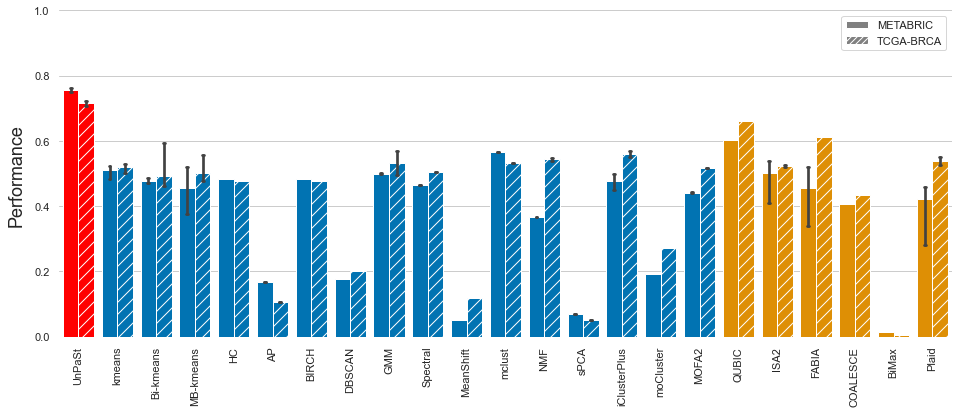

In [10]:
import settings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.patches import Rectangle
import matplotlib

 
    
    
sns.set_theme(style="whitegrid")

%matplotlib inline

cancer_types = []
for _, values in settings.CANCER_GROUPS:
    cancer_types.extend(values)


def clean_columns(df):
    if 'seed' in df: del df['seed']
    if 'run' in df: del df['run']
    if 'time' in df: del df['time']
    if 'parameters' in df: del df['parameters']
    if 'Unnamed: 0' in df: del df['Unnamed: 0']
    return df

def remove_substring_from_params(x, string, chars_right):
    pos = x.find(string)
    if pos > -1:
        return x[:pos] + x[pos + len(string) + chars_right:]
    return x


### 1 Collect data
data = {dataset: {d: pd.DataFrame() for d in settings.REAL_DATASETS} for dataset in settings.REAL_DATASETS}

table_key = 'PAM50'
found_methods = set()
df_data_plot = pd.DataFrame()
for method in settings.METHODS:
    df_all_raw = pd.DataFrame()
    df_all_mean = pd.DataFrame()
    for dataset in settings.REAL_DATASETS:
        try:
            df = pd.DataFrame()
            file_path = os.path.join(PATH_TO_REAL_RESULTS, f'{method}_{dataset}.tsv')
            df_cur = pd.read_csv(file_path, sep='\t')
            df_cur = df_cur.rename(columns={'param': 'parameters'})
            if 'seed' not in df_cur.columns and 'seeds=' in df_cur.iloc[0]['parameters']:
                # assumes that seeds= is last parameter, grandforest
                df_cur['seed'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[-1])
                df_cur['run'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[-1])
                df_cur['parameters'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[0])
            
            df_cur = df_cur.dropna(axis=0, subset=['parameters'])
            df_cur['dataset'] = dataset
            df = pd.concat([df, df_cur])
        except:
            print(f'Warning: No file found for {method} on real data.')
            break
            
        found_methods.add(method)
        # merge runs with different seeds
        df['Dataset'] = dataset 
        df['Method'] = method 
        if 'run' in df or not df["parameters"].is_unique:
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'random_state=', 2))
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'TCGA', 0))
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'METABRIC', 0))
            df_mean = df.groupby('parameters').mean()
            df_mean = df_mean.reset_index()
        df_all_mean = pd.concat([df_all_mean, df_mean])
        df_all_raw = pd.concat([df_all_raw, df])
    
    if len(df_all_raw) == 0:
        continue

    for dataset in settings.REAL_DATASETS:
        df_sub_raw = df_all_raw[df_all_raw['Dataset']==dataset]
        df_sub_raw = df_sub_raw[df_sub_raw['parameters']==best_average_rank_brca_string[method]]
        df_data_plot = pd.concat([df_data_plot, df_sub_raw])


order = [method for method in settings.METHODS if method in found_methods]
order = [settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x for x in order]
order = [x.replace('_', ' ') for x in order]

### 2 Plot w/o network constraint methods
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(16, 6))
    
# remove network constraint methods
df_data_plot = df_data_plot[~df_data_plot['Method'].isin(settings.METHODS_NETWORK_CONSTRAINT)]
_order = [x for x in order if x not in settings.METHODS_NETWORK_CONSTRAINT]

df_data_plot['Method'] = df_data_plot['Method'].map(lambda x: settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x)
df_data_plot['Method'] = df_data_plot['Method'].map(lambda x: x.replace('_', ' '))
df_data_plot[table_key] = pd.to_numeric(df_data_plot[table_key])

#  rename dataset to 'TCGA-BRCA' if label is 'TCGA'
df_data_plot['Dataset'] = df_data_plot['Dataset'].map(lambda x: 'TCGA-BRCA' if x == 'TCGA' else x)

palette = ['grey', 'grey']

sub_fig = sns.barplot(palette=palette, hue_order=['METABRIC', 'TCGA-BRCA'], data=df_data_plot, x='Method',  y=table_key, hue='Dataset', ax=axs, estimator=np.mean, errorbar=(lambda x: (min(x), max(x))), capsize=.05, order=_order) #palette=settings.METHOD_PALETTE
plt.legend(loc='upper right')
axs.tick_params(axis='x', rotation=90)
axs.set(ylim=(0, 1))

palette = [settings.METHOD_PALETTE[x] for x in _order if x in settings.METHOD_PALETTE]
for bars, hatch, legend_handle in zip(sub_fig.containers, ['', '//'], sub_fig.legend_.legendHandles):
    for bar, color in zip(bars, palette):
        bar.set_facecolor(color)
        bar.set_hatch(hatch)
    # update the existing legend, use twice the hatching pattern to make it denser
    legend_handle.set_hatch(hatch + hatch)
    legend_handle.set_label('test')

sns.despine(bottom = True, left = True, right=True, top=True)
sub_fig.set(xlabel=None, ylabel=None)

fig.text(0.08, 0.5, 'Performance', va='center', rotation='vertical', fontsize=18)
fig.subplots_adjust(hspace=.5)

plt.savefig(f'paper/Figure4_A.png', dpi=300,bbox_inches='tight')

# Figure S4 B: BRCA performance gain after parameter optimization (tuned on TCGA or METABRIC vs. default parameters)

/var/folders/k5/qbs_42rd35j4mmpzqs47hdrw0000gn/T/ipykernel_38792/3374895219.py:212: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for bars, hatch, legend_handle in zip(sub_fig.containers, ['', '//'], sub_fig.legend_.legendHandles):


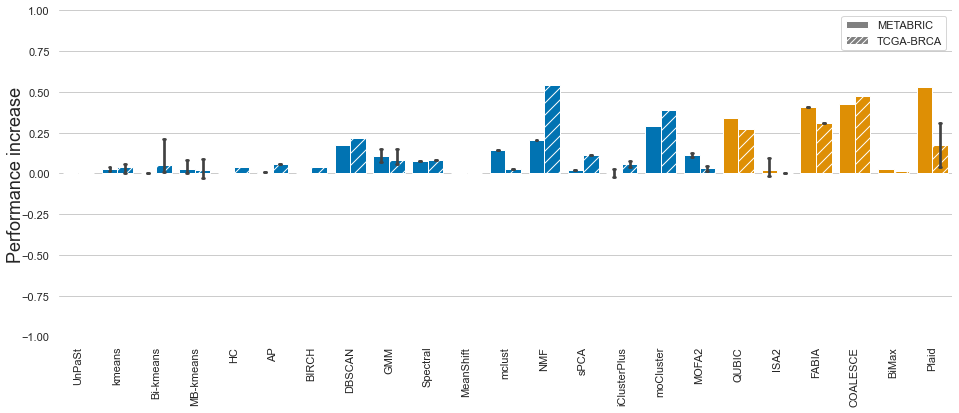

In [11]:
import settings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.patches import Rectangle
import matplotlib


sns.set_theme(style="whitegrid")

%matplotlib inline

cancer_types = []
for _, values in settings.CANCER_GROUPS:
    cancer_types.extend(values)


def clean_columns(df):
    if 'seed' in df: del df['seed']
    if 'run' in df: del df['run']
    if 'time' in df: del df['time']
    if 'parameters' in df: del df['parameters']
    if 'Unnamed: 0' in df: del df['Unnamed: 0']
    return df

def remove_substring_from_params(x, string, chars_right):
    pos = x.find(string)
    if pos > -1:
        return x[:pos] + x[pos + len(string) + chars_right:]
    return x


### 1 Collect data
data = {dataset: {d: pd.DataFrame() for d in ['METABRIC', 'TCGA', 'DEFAULT']} for dataset in ['METABRIC','TCGA', 'DEFAULT']}
default_params = {d: {} for d in ['METABRIC', 'TCGA', 'DEFAULT']}

table_key = 'PAM50'
found_methods = set()
for dataset in ['TCGA', 'METABRIC']:
    for method in settings.METHODS:
        try:
            df = pd.DataFrame()
            file_path = os.path.join(PATH_TO_REAL_RESULTS, f'{method}_{dataset}.tsv')
            df_cur = pd.read_csv(file_path, sep='\t')
            df_cur = df_cur.rename(columns={'param': 'parameters'})
            if 'seed' not in df_cur.columns and 'seeds=' in df_cur.iloc[0]['parameters']:
                # assumes that seeds= is last parameter, grandforest
                df_cur['seed'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[-1])
                df_cur['run'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[-1])
                df_cur['parameters'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[0])
            
            df_cur = df_cur.dropna(axis=0, subset=['parameters'])
            df_cur['dataset'] = dataset
            df = pd.concat([df, df_cur])
        except:
            print(f'Warning: No file found for {method} on real data.')
            continue
        found_methods.add(method)
        # merge runs with different seeds
        if 'run' in df or not df["parameters"].is_unique:
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'random_state=', 1))
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'TCGA', 0))
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'METABRIC', 0))
            df_mean = df.groupby('parameters').mean()
        else:
            df_mean = df.set_index('parameters')
        df_mean = clean_columns(df_mean)
        df_mean = df_mean[table_key]
        if method != 'UnPaSt':
            # unpast has no default params
            
            for params_string in df_mean.index:  
                if method not in settings.DEFAULT_PARAMETERS:
                    flag = False
                    break
                for k, v in settings.DEFAULT_PARAMETERS[method].items():
                    flag = True
                    if not f'{k.lower()}={str(v).lower()}' in params_string.lower():
                        flag = False
                        break
                # if we reach this, default params string found
                if flag:
                    break
            if not flag:
                # raise Exception(f'Could not find default parameters for {method}.')
                print(f'Could not find default parameters for {method}.')
            else:
                default_params[dataset][method] = params_string

        else:
            pass

        
found_methods = set()
for dataset in ['TCGA', 'METABRIC']:
    for method in settings.METHODS:
        try:
            df = pd.DataFrame()
            for _dataset in settings.REAL_DATASETS:
                file_path = os.path.join(PATH_TO_REAL_RESULTS, f'{method}_{_dataset}.tsv')
                df_cur = pd.read_csv(file_path, sep='\t')
                df_cur = df_cur.rename(columns={'param': 'parameters'})
                if 'seed' not in df_cur.columns and 'seeds=' in df_cur.iloc[0]['parameters']:
                    # assumes that seeds= is last parameter, grandforest
                    df_cur['seed'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[-1])
                    df_cur['run'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[-1])
                    df_cur['parameters'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[0])

                df_cur = df_cur.dropna(axis=0, subset=['parameters'])
                df_cur['dataset'] = _dataset
                df = pd.concat([df, df_cur])
        except:
            print(f'Warning: No file found for {method} on real data.')
            continue
        found_methods.add(method)
        # merge runs with different seeds
        if 'run' in df or not df["parameters"].is_unique:
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'random_state=', 1))
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'TCGA', 0))
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'METABRIC', 0))
        
        if method not in default_params[dataset]:
            if method == 'COALESCE':
                pass
            else:
                # default params not found
                continue
        
        top_params = best_params[dataset][method]
        df_top_values = df[df['parameters']==top_params]
        df_top_values = clean_columns(df_top_values)
        # limit to used cancer types
        df_top_values = df_top_values[[table_key, 'dataset']]
        # format for sns input
        df_top_values_sub = df_top_values[df_top_values['dataset']==dataset]
        del df_top_values_sub['dataset']
        df_top_values_sub = df_top_values_sub.melt()
        df_top_values_sub['Method'] = method
        df_top_values_sub = df_top_values_sub.rename(columns={'value': 'Jaccard index', 'variable': 'Cancer type'})
        data[dataset][dataset] = pd.concat([data[dataset][dataset], df_top_values_sub])
        
        if method == 'COALESCE':
            df_top_values_sub = pd.DataFrame({'Cancer type': {0: 'PAM50'},
                 'Jaccard index': {0: 0},
                 'Method': {0: 'COALESCE'}})
            data[dataset]['DEFAULT'] = pd.concat([data[dataset]['DEFAULT'], df_top_values_sub])
            continue
            
        default_p = default_params[dataset][method]
        df_top_values = df[df['parameters']==default_p]
        df_top_values = clean_columns(df_top_values)
        # limit to used cancer types
        df_top_values = df_top_values[[table_key, 'dataset']]
        # format for sns input
        df_top_values_sub = df_top_values[df_top_values['dataset']==dataset]
        del df_top_values_sub['dataset']
        df_top_values_sub = df_top_values_sub.melt()
        df_top_values_sub['Method'] = method
        df_top_values_sub = df_top_values_sub.rename(columns={'value': 'Jaccard index', 'variable': 'Cancer type'})
        
        data[dataset]['DEFAULT'] = pd.concat([data[dataset]['DEFAULT'], df_top_values_sub])


order = [method for method in settings.METHODS if method in found_methods]
order = [settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x for x in order]
order = [x.replace('_', ' ') for x in order]

### 2 Plot w/o network constraint methods
datasets = ['TCGA', 'METABRIC']
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(16, 6))
df_plot = pd.DataFrame()
for i, dataset in enumerate(datasets):
    plt.subplots_adjust(hspace=0.6)
    
    df_cur = data[dataset][dataset].copy().reset_index()
    df_cur['index'] = df_cur['Method'] + df_cur['index'].map(str)
    df_cur = df_cur.set_index('index')
    data[dataset][dataset] = df_cur

    df_cur = data[dataset]['DEFAULT'].copy().reset_index()
    df_cur['index'] = df_cur['Method'] + df_cur['index'].map(str)
    df_cur = df_cur.set_index('index')
    data[dataset]['DEFAULT'] = df_cur

    data[dataset][dataset]['Jaccard index'] = data[dataset][dataset]['Jaccard index'] - data[dataset]['DEFAULT']['Jaccard index']
    sub_df = data[dataset][dataset]

    # remove network constraint methods
    sub_df = sub_df[~sub_df['Method'].isin(settings.METHODS_NETWORK_CONSTRAINT)]
    _order = [x for x in order if x not in settings.METHODS_NETWORK_CONSTRAINT]
    
    sub_df['Method'] = sub_df['Method'].map(lambda x: settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x)
    sub_df['Method'] = sub_df['Method'].map(lambda x: x.replace('_', ' '))
    sub_df['Jaccard index'] = pd.to_numeric(sub_df['Jaccard index'])
    sub_df['Dataset'] = dataset
    df_plot = pd.concat([df_plot, sub_df])
    

df_plot.loc[f'UnPaSt0'] = ['PAM50', 0, 'UnPaSt', 'TCGA']
df_plot.loc[f'UnPaSt1'] = ['PAM50', 0, 'UnPaSt', 'METABRIC']

#  rename dataset to 'TCGA-BRCA' if label is 'TCGA'
df_plot['Dataset'] = df_plot['Dataset'].map(lambda x: 'TCGA-BRCA' if x == 'TCGA' else x)

palette=['grey', 'grey']
sub_fig = sns.barplot(palette=palette, hue_order=['METABRIC', 'TCGA-BRCA'], hue='Dataset', data=df_plot, x='Method',  y='Jaccard index', ax=axs, estimator=np.mean, errorbar=(lambda x: (min(x), max(x))), capsize=.05, order=_order) #palette=settings.METHOD_PALETTE
plt.legend(loc='upper right')
# unpast no default values
palette = [settings.METHOD_PALETTE[x] for x in _order if x in settings.METHOD_PALETTE]
for bars, hatch, legend_handle in zip(sub_fig.containers, ['', '//'], sub_fig.legend_.legendHandles):
    for bar, color in zip(bars, palette):
        bar.set_facecolor(color)
        bar.set_hatch(hatch)
    # update the existing legend, use twice the hatching pattern to make it denser
    legend_handle.set_hatch(hatch + hatch)
        
axs.tick_params(axis='x', rotation=90)
axs.set(ylim=(-1, 1))

sns.despine(bottom = True, left = True, right=True, top=True)
sub_fig.set(xlabel=None, ylabel=None)

fig.text(0.08, 0.5, 'Performance increase', va='center', rotation='vertical', fontsize=18)

fig.subplots_adjust(hspace=.5)

# plt.savefig(f'paper/supplement/FigureS4_C.png', dpi=300,bbox_inches='tight')


# Figure 4 B: BRCA performance optimized (best_average_rank_brca_string) minus default per dataset

/var/folders/k5/qbs_42rd35j4mmpzqs47hdrw0000gn/T/ipykernel_38792/2631070618.py:208: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for bars, hatch, legend_handle in zip(sub_fig.containers, ['', '//'], sub_fig.legend_.legendHandles):


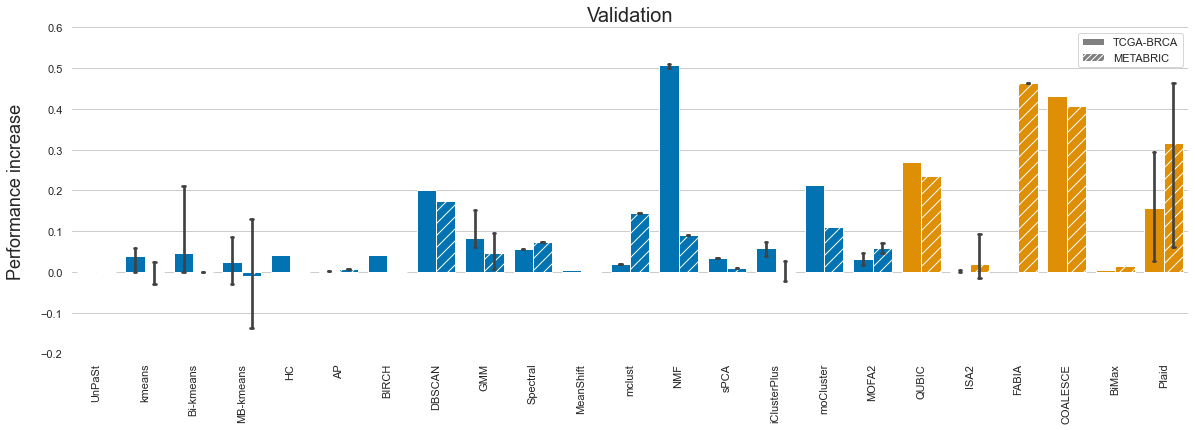

In [12]:
import settings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.patches import Rectangle
import matplotlib


sns.set_theme(style="whitegrid")

%matplotlib inline

cancer_types = []
for _, values in settings.CANCER_GROUPS:
    cancer_types.extend(values)


def clean_columns(df):
    if 'seed' in df: del df['seed']
    if 'run' in df: del df['run']
    if 'time' in df: del df['time']
    if 'parameters' in df: del df['parameters']
    if 'Unnamed: 0' in df: del df['Unnamed: 0']
    return df

def remove_substring_from_params(x, string, chars_right):
    pos = x.find(string)
    if pos > -1:
        return x[:pos] + x[pos + len(string) + chars_right:]
    return x


### 1 Collect data
data = {dataset: {d: pd.DataFrame() for d in ['METABRIC', 'TCGA', 'DEFAULT', 'OPTIMIZED']} for dataset in ['METABRIC','TCGA', 'DEFAULT', 'OPTIMIZED']}
default_params = {d: {} for d in ['METABRIC', 'TCGA', 'DEFAULT', 'OPTIMIZED']}

table_key = 'PAM50'
found_methods = set()
for dataset in ['TCGA', 'METABRIC']:
    for method in settings.METHODS:
        try:
            df = pd.DataFrame()
            file_path = os.path.join(PATH_TO_REAL_RESULTS, f'{method}_{dataset}.tsv')
            df_cur = pd.read_csv(file_path, sep='\t')
            df_cur = df_cur.rename(columns={'param': 'parameters'})
            if 'seed' not in df_cur.columns and 'seeds=' in df_cur.iloc[0]['parameters']:
                # assumes that seeds= is last parameter, grandforest
                df_cur['seed'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[-1])
                df_cur['run'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[-1])
                df_cur['parameters'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[0])
            
            df_cur = df_cur.dropna(axis=0, subset=['parameters'])
            df_cur['dataset'] = dataset
            df = pd.concat([df, df_cur])
        except:
            print(f'Warning: No file found for {method} on real data.')
            continue
        found_methods.add(method)
        # merge runs with different seeds
        if 'run' in df or not df["parameters"].is_unique:
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'random_state=', 2))
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'TCGA', 0))
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'METABRIC', 0))
            df_mean = df.groupby('parameters').mean()
        else:
            df_mean = df.set_index('parameters')
        df_mean = clean_columns(df_mean)
        df_mean = df_mean[table_key]
        if method != 'UnPaSt':
            # unpast has no default params
            
            for params_string in df_mean.index:  
                if method not in settings.DEFAULT_PARAMETERS:
                    flag = False
                    break
                for k, v in settings.DEFAULT_PARAMETERS[method].items():
                    flag = True
                    if not f'{k.lower()}={str(v).lower()}' in params_string.lower():
                        flag = False
                        break
                # if we reach this, default params string found
                if flag:
                    break
            if not flag:
                # raise Exception(f'Could not find default parameters for {method}.')
                print(f'Could not find default parameters for {method}.')
            else:
                default_params[dataset][method] = params_string
        else:
            pass

        
found_methods = set()
for dataset in ['TCGA', 'METABRIC']:
    for method in settings.METHODS:
        try:
            df = pd.DataFrame()
            for _dataset in settings.REAL_DATASETS:
                file_path = os.path.join(PATH_TO_REAL_RESULTS, f'{method}_{_dataset}.tsv')
                df_cur = pd.read_csv(file_path, sep='\t')
                df_cur = df_cur.rename(columns={'param': 'parameters'})
                if 'seed' not in df_cur.columns and 'seeds=' in df_cur.iloc[0]['parameters']:
                    # assumes that seeds= is last parameter, grandforest
                    df_cur['seed'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[-1])
                    df_cur['run'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[-1])
                    df_cur['parameters'] = df_cur['parameters'].map(lambda x: x.split('seeds=')[0])

                df_cur = df_cur.dropna(axis=0, subset=['parameters'])
                df_cur['dataset'] = _dataset
                df = pd.concat([df, df_cur])
        except:
            print(f'Warning: No file found for {method} on real data.')
            continue
        found_methods.add(method)
        # merge runs with different seeds
        if 'run' in df or not df["parameters"].is_unique:
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'random_state=', 2))
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'TCGA', 0))
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'METABRIC', 0))
        
        if method not in default_params[dataset]:
            if method == 'COALESCE':
                pass
            else:
                # default params not found
                continue
        
        top_params = best_average_rank_brca_string[method]
        df_top_values = df[df['parameters']==top_params]
        df_top_values = clean_columns(df_top_values)
        # limit to used cancer types
        df_top_values = df_top_values[[table_key, 'dataset']]
        # format for sns input
        df_top_values_sub = df_top_values[df_top_values['dataset']==dataset]
        del df_top_values_sub['dataset']
        df_top_values_sub = df_top_values_sub.melt()
        df_top_values_sub['Method'] = method
        df_top_values_sub = df_top_values_sub.rename(columns={'value': 'Jaccard index', 'variable': 'Cancer type'})
        data[dataset]['OPTIMIZED'] = pd.concat([data[dataset]['OPTIMIZED'], df_top_values_sub])
        
        if method == 'COALESCE':
            df_top_values_sub = pd.DataFrame({'Cancer type': {0: 'PAM50'},
                 'Jaccard index': {0: 0},
                 'Method': {0: 'COALESCE'}})
            data[dataset]['DEFAULT'] = pd.concat([data[dataset]['DEFAULT'], df_top_values_sub])
            continue
            
        default_p = default_params[dataset][method]
        df_top_values = df[df['parameters']==default_p]
        df_top_values = clean_columns(df_top_values)
        # limit to used cancer types
        df_top_values = df_top_values[[table_key, 'dataset']]
        # format for sns input
        df_top_values_sub = df_top_values[df_top_values['dataset']==dataset]
        del df_top_values_sub['dataset']
        df_top_values_sub = df_top_values_sub.melt()
        df_top_values_sub['Method'] = method
        df_top_values_sub = df_top_values_sub.rename(columns={'value': 'Jaccard index', 'variable': 'Cancer type'})
        data[dataset]['DEFAULT'] = pd.concat([data[dataset]['DEFAULT'], df_top_values_sub])
        

order = [method for method in settings.METHODS if method in found_methods]
order = [settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x for x in order]
order = [x.replace('_', ' ') for x in order]

### 2 Plot w/o network constraint methods
datasets = ['METABRIC', 'TCGA']
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(20, 6))
df_plot = pd.DataFrame()
for i, dataset in enumerate(datasets):
    
    df_cur = data[dataset]['OPTIMIZED'].copy().reset_index()
    df_cur['index'] = df_cur['Method'] + df_cur['index'].map(str)
    df_cur = df_cur.set_index('index')
    data[dataset]['OPTIMIZED'] = df_cur

    df_cur = data[dataset]['DEFAULT'].copy().reset_index()
    df_cur['index'] = df_cur['Method'] + df_cur['index'].map(str)
    df_cur = df_cur.set_index('index')
    data[dataset]['DEFAULT'] = df_cur
            
    data[dataset]['OPTIMIZED']['Jaccard index'] = data[dataset]['OPTIMIZED']['Jaccard index'] - data[dataset]['DEFAULT']['Jaccard index']
    sub_df = data[dataset]['OPTIMIZED']

    # remove network constraint methods
    sub_df = sub_df[~sub_df['Method'].isin(settings.METHODS_NETWORK_CONSTRAINT)]
    _order = [x for x in order if x not in settings.METHODS_NETWORK_CONSTRAINT]
    
    sub_df['Method'] = sub_df['Method'].map(lambda x: settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x)
    sub_df['Method'] = sub_df['Method'].map(lambda x: x.replace('_', ' '))
    sub_df['Jaccard index'] = pd.to_numeric(sub_df['Jaccard index'])
    sub_df['Dataset'] = dataset
    df_plot = pd.concat([df_plot, sub_df])
    

df_plot.loc[f'UnPaSt0'] = ['PAM50', 0, 'UnPaSt', 'TCGA']
df_plot.loc[f'UnPaSt1'] = ['PAM50', 0, 'UnPaSt', 'METABRIC']

#  rename dataset to 'TCGA-BRCA' if label is 'TCGA'
df_plot['Dataset'] = df_plot['Dataset'].map(lambda x: 'TCGA-BRCA' if x == 'TCGA' else x)
    
palette=['grey', 'grey']
sub_fig = sns.barplot(palette=palette, hue_order=['TCGA-BRCA', 'METABRIC'], hue='Dataset', data=df_plot, x='Method',  y='Jaccard index', ax=axs, estimator=np.mean, errorbar=(lambda x: (min(x), max(x))), capsize=.05, order=_order) #palette=settings.METHOD_PALETTE
plt.legend(loc='upper right')
palette = [settings.METHOD_PALETTE[x] for x in _order if x in settings.METHOD_PALETTE]
for bars, hatch, legend_handle in zip(sub_fig.containers, ['', '//'], sub_fig.legend_.legendHandles):
    for bar, color in zip(bars, palette):
        bar.set_facecolor(color)
        bar.set_hatch(hatch)
    # update the existing legend, use twice the hatching pattern to make it denser
    legend_handle.set_hatch(hatch + hatch)

axs.tick_params(axis='x', rotation=90)
axs.set(ylim=(0, 1))
axs.set_title(f"Validation", fontsize=20)

sns.despine(bottom = True, left = True, right=True, top=True)
sub_fig.set(xlabel=None, ylabel=None)

fig.text(0.08, 0.5, 'Performance increase', va='center', rotation='vertical', fontsize=18)
fig.subplots_adjust(hspace=.5)

axs.set_ylim(-.2,0.6)

plt.savefig(f'paper/supplement/FigureS5_C.png', dpi=300,bbox_inches='tight')


# Figure 4 C: Violin plot of all performances of all algorithms on TCGA & METABRIC

No data for AgglomerativeClustering TCGA
No data for AgglomerativeClustering METABRIC
No data for Optics TCGA
No data for Optics METABRIC
No data for QUBIC2 TCGA
No data for QUBIC2 METABRIC
No data for BiCoN TCGA
No data for BiCoN METABRIC
No data for DESMOND TCGA
No data for DESMOND METABRIC
No data for GrandForest TCGA
No data for GrandForest METABRIC


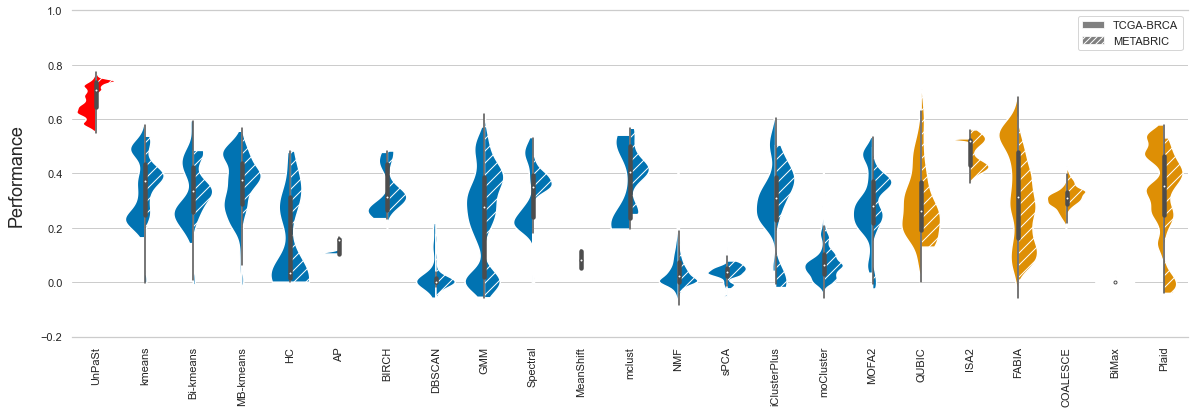

In [13]:
import settings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.patches import Rectangle
import matplotlib
sns.set_theme(style="whitegrid")

table_key = 'PAM50'

def get_data_path(method, dataset):
    return os.path.join(PATH_TO_REAL_RESULTS, f'{method}_{dataset}.tsv')

# load data
data = {dataset: {} for dataset in settings.REAL_DATASETS}
for method in settings.METHODS:
    for dataset in settings.REAL_DATASETS:        
        path = get_data_path(method, dataset)
        try:
            df = pd.read_csv(path, sep='\t')
            assert len(df)
        except:
            print(f'No data for {method} {dataset}')
            continue
        m = method.replace('_', ' ')
        m = settings.METHOD_ABBREVIATIONS[m] if m in settings.METHOD_ABBREVIATIONS else m
        data[dataset][m] = df[table_key].tolist()

# found_methods from plot above
order = [method for method in settings.METHODS if method in found_methods]
order = [settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x for x in order]
order = [x.replace('_', ' ') for x in order]      
                
# plot without network constraint mehtods
fig, ax = plt.subplots(1, 1, figsize=(20, 6), sharex=True, sharey=True)
df_plot_all = pd.DataFrame()
for i, dataset in enumerate(settings.REAL_DATASETS):
    series_list = []
    for method, values in data[dataset].items():
        s = pd.Series(values, name=method)
        series_list.append(s)
    df_plot = pd.concat(series_list, axis=1)
    
        
    # remove network constraint methods
    df_plot = df_plot.melt()
    df_plot = df_plot[~df_plot['variable'].isin(settings.METHODS_NETWORK_CONSTRAINT)]
    
    df_plot['dataset'] = dataset
    df_plot_all = pd.concat([df_plot_all, df_plot])
    
_order = [x for x in order if x not in settings.METHODS_NETWORK_CONSTRAINT] 

df_plot_all['variable'] = df_plot_all['variable'].replace('sparse PCA', 'sPCA')

#  rename dataset to 'TCGA-BRCA' if label is 'TCGA'
df_plot_all['dataset'] = df_plot_all['dataset'].map(
    lambda x: 'TCGA-BRCA' if x == 'TCGA' else x)

palette = ['grey', 'grey']
sub_fig = sns.violinplot(data=df_plot_all, gap=.1, split=True, fill=False, palette=palette, x="variable", y="value", hue='dataset', ax=ax, scale="width", cut=0, order=_order) # inner="stick",    
plt.legend(loc='upper right')
hatches = cycle(['', '//'])
palette = iter([settings.METHOD_PALETTE[x] for x in _order if x in settings.METHOD_PALETTE])
prev_i = None
color = next(palette)
for i, patch in enumerate(sub_fig.get_children()):
    if not isinstance(patch, matplotlib.collections.PolyCollection):
        continue
    # Boxes from left to right
    hatch = next(hatches)
    patch.set_hatch(hatch)
    if prev_i is not None and i - prev_i == 1:
        color = next(palette)
    patch.set_facecolor(color)
    patch.set_edgecolor('white')
    prev_i = i

for i, hatch in enumerate(['', '//']):
    sub_fig.legend_.legend_handles[i].set_hatch(hatch + hatch)
    sub_fig.legend_.legend_handles[i].set_edgecolor('white')

    
ax.tick_params(axis='x', rotation=90) # 
ax.set(ylim=(-.2, 1))

sub_fig.set(xlabel=None, ylabel=None)
sns.despine(bottom = False, left = True, right=True, top=False)

# plt.legend(settings.METHODS)
fig.text(0.08, 0.5, 'Performance', va='center', rotation='vertical', fontsize=18)

plt.savefig(f'paper/supplement/FigureS5_D.png', dpi=300,bbox_inches='tight')

# Figure Sx: Heatmaps of simulated expression data

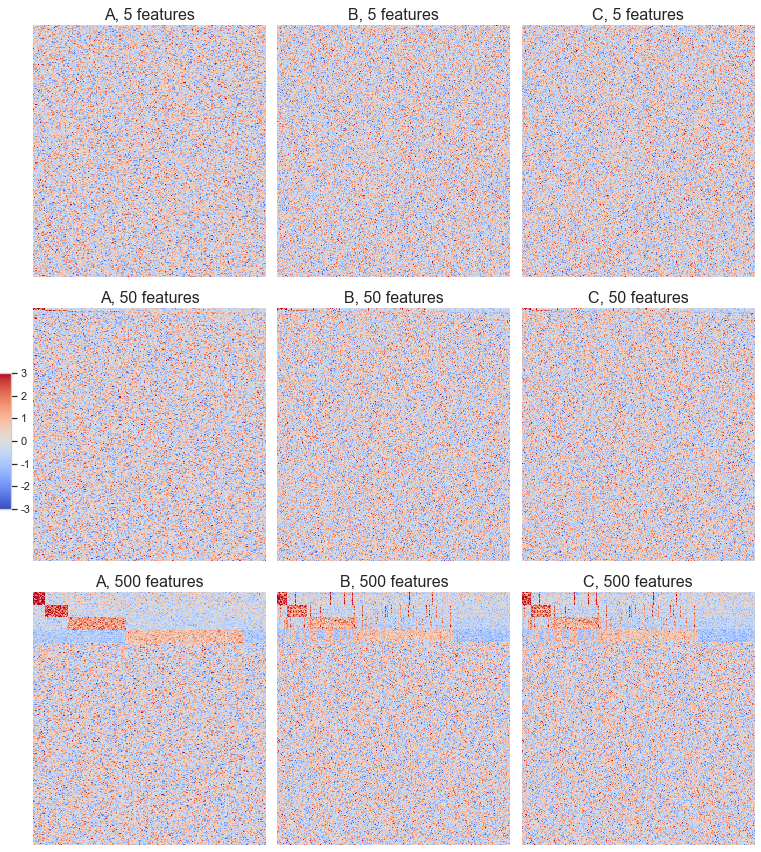

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False, figsize=(12, 12))

for i, n in enumerate([5, 50, 500]):
    for j, scenario in enumerate(['A', 'B', 'C']):
        overlap = 'no' if scenario == 'A' else 'yes'
        exprs_path = os.path.join(PATH_TO_SIMULATED_DATA, f'{scenario}.n_genes={n},m=4,std=1,overlap={overlap}.exprs_z.tsv')
        truth_path = os.path.join(PATH_TO_SIMULATED_DATA, f'{scenario}.n_genes={n},m=4,std=1,overlap={overlap}.biclusters.tsv')
    
        exprs = pd.read_csv(exprs_path, sep='\t', index_col=0)
        ground_truth = pd.read_csv(truth_path, sep='\t', index_col=0)

        ground_truth['genes'] = ground_truth['genes'].map(lambda x: x.split(' '))
        ground_truth['samples'] = ground_truth['samples'].map(lambda x: x.split(' '))

        bic_g = []
        bic_s = []
        for row in ground_truth.iterrows():
            bic = row[1]
            g = list(bic["genes"])
            s = list(bic["samples"])
            bic_g += g
            bic_s += s
        for module in coexpressed_modules:
            bic_g +=  [x for x in module if not x in bic_g]

        bg_g = set(exprs.index.values).difference(set(bic_g))
        bg_s = set(exprs.columns.values).difference(set(bic_s))

        samples = bic_s + list(bg_s)
        genes = bic_g + list(bg_g)

        axs[i, j].set_title(f'{scenario}, {n} features', fontsize=16)
        
        exprs = zscore(exprs)
        cg = sns.heatmap(zscore(exprs.loc[bic_g+sorted(bg_g),bic_s+sorted(bg_s)]),
                            xticklabels=False,yticklabels=False, cbar=False,
                            cmap=sns.color_palette("coolwarm", as_cmap=True),vmin=-3,vmax=3, ax=axs[i, j])


legend_heatmap = plt.imread('legend_heatmap.png')
# legend_heatmap.resize((200,10))
axs[0, 0].figure.figimage(legend_heatmap, -10, 330, alpha=1)

fig.text(0.12, 0.205, ' ', va='center', rotation='vertical', fontsize=18)

plt.tight_layout()
plt.subplots_adjust(left=.15)

sns.despine(bottom = True, left = True, right=True, top=True)

# plt.savefig(f'paper/supplement/FigureSx.png', dpi=300, bbox_inches='tight')

# Figure Sx: Heatmaps of evaluation on each breast cancer dataset

Index(['Unnamed: 0', 'PAM50', 'Intrinsic', 'PAM50_AB', 'SCMOD2', 'IHC',
       'Luminal', 'Basal', 'Her2', 'LumA', 'LumB', 'Normal', 'Claudin-low',
       'IHC_HER2', 'IHC_ER', 'IHC_PR', 'IHC_TNBC', 'NET_kmeans', 'NET_ward',
       'parameters', 'seed', 'run', 'time'],
      dtype='object')
Index(['PAM50', 'dataset'], dtype='object')
Index(['variable', 'value', 'Method'], dtype='object')
Index(['Unnamed: 0', 'PAM50', 'Intrinsic', 'PAM50_AB', 'SCMOD2', 'IHC',
       'Luminal', 'Basal', 'Her2', 'LumA', 'LumB', 'Normal', 'Claudin-low',
       'IHC_HER2', 'IHC_ER', 'IHC_PR', 'IHC_TNBC', 'NET_kmeans', 'NET_ward',
       'parameters', 'seed', 'run', 'time'],
      dtype='object')
Index(['Cancer type', 'ARI', 'Method'], dtype='object')
Index(['variable', 'value', 'Method'], dtype='object')
Index(['Unnamed: 0', 'PAM50', 'Intrinsic', 'PAM50_AB', 'SCMOD2', 'IHC',
       'Luminal', 'Basal', 'Her2', 'LumA', 'LumB', 'Normal', 'Claudin-low',
       'IHC_HER2', 'IHC_ER', 'IHC_PR', 'IHC_TNBC', 'NET_km

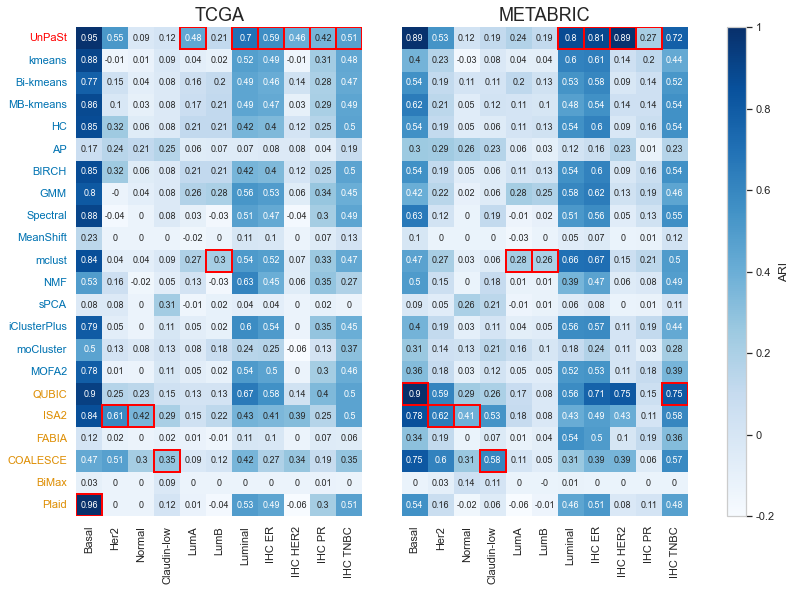

In [15]:
import settings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.patches import Rectangle
import matplotlib
import matplotlib.cm as cm

sns.set_theme(style="whitegrid")

%matplotlib inline


cancer_types = []
for _, values in settings.CANCER_GROUPS:
    cancer_types.extend(values)


def clean_columns(df):
    if 'seed' in df: del df['seed']
    if 'run' in df: del df['run']
    if 'time' in df: del df['time']
    if 'parameters' in df: del df['parameters']
    if 'Unnamed: 0' in df: del df['Unnamed: 0']
    return df

def remove_substring_from_params(x, string, chars_right):
    pos = x.find(string)
    if pos > -1:
        return x[:pos] + x[pos + len(string) + chars_right:]
    return x


### 1 Collect data
data = {d: pd.DataFrame() for d in settings.REAL_DATASETS}
data_ihc = {}

table_key = 'PAM50'

for method in settings.METHODS:
    if method == 'DBSCAN':
        continue
    
    for dataset in settings.REAL_DATASETS:
        try:
            file_path = os.path.join(PATH_TO_REAL_RESULTS, f'{method}_{dataset}.tsv')
            df = pd.read_csv(file_path, sep='\t')
            df = df.rename(columns={'param': 'parameters'})
            df = df.dropna(axis=0, subset=['parameters'])
            print(df.columns)
        except Exception as e:
#             print(e)
            print(f'Warning: No file found for {method} on real data.')
            continue
        
        # merge runs with different seeds
        if 'run' in df or not df["parameters"].is_unique:
            df['parameters'] = df['parameters'].map(lambda x: remove_substring_from_params(x, 'random_state=', 2))
            df = df.fillna(0)
            df_mean = df.groupby('parameters').mean()
        else:
            df_mean = df.set_index('parameters')
        df_mean = clean_columns(df_mean)
#         top_params = df_mean[table_key].sort_values(ascending=False).index[0]
#         top_params = best_params[dataset][method]
        top_params = best_average_rank_brca_string[method]
        print(df_top_values.columns)
        df_top_values = df[df['parameters']==top_params]
        df_top_values = clean_columns(df_top_values)
        # format for sns input
        df_top_values = df_top_values.melt()
        df_top_values['Method'] = method
        
        print(df_top_values.columns)
            
        df_top_values = df_top_values.rename(columns={'value': 'ARI', 'variable': 'Cancer type'})
            
        data[dataset] = pd.concat([data[dataset], df_top_values])



cancer_types = []
for _, values in settings.CANCER_GROUPS:
    cancer_types.extend(values)
    
methods = data[dataset]['Method'].unique()
methods = [settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x for x in methods]

fig, axs = plt.subplots(1, len(settings.REAL_DATASETS) + 1, sharex=False, sharey=False, figsize=(12, 9), gridspec_kw={'width_ratios': [15, 15, 1]})
for y, scenario in enumerate(settings.REAL_DATASETS):
    plot_data_df = pd.DataFrame()
    for i, cancer_type in enumerate(cancer_types):
        data_sub = data[scenario][data[scenario]['Cancer type']==cancer_type].copy()
        data_sub['Method'] = data_sub['Method'].map(lambda x: settings.METHOD_ABBREVIATIONS[x] if x in settings.METHOD_ABBREVIATIONS else x)
        data_sub['Method'] = data_sub['Method'].map(lambda x: x.replace('_', ' '))
        del data_sub['Cancer type']
        data_sub['ARI'] = data_sub['ARI'].astype(float)
        data_sub = data_sub.groupby('Method').mean()
        data_sub = data_sub.reindex(methods).reset_index(drop=True)
        data_sub['Method'] = [i for i in range(len(methods))]
        data_sub['Cancer type'] = cancer_type.replace('_', ' ')
        plot_data_df = pd.concat([plot_data_df, data_sub])
        
    # collect indices for red highlight
    data_pivot = plot_data_df.pivot(index='Method', columns='Cancer type')['ARI']
    order = [x.replace('_', ' ') for x in cancer_types]
    data_pivot = data_pivot[order]
    max_indices_list = []
    for cancer_type in data_pivot.columns:
        max_value = data_pivot[cancer_type].max()
        max_indices = data_pivot[cancer_type][data_pivot[cancer_type]==max_value].index.tolist()
        max_indices_list.append(max_indices)
    data_pivot = data_pivot.applymap(lambda x: round(x, 2))
    
    yticklabels = methods if y == 0 else False
    sub_fig = sns.heatmap(data_pivot, annot=True, 
                          yticklabels=yticklabels, ax=axs[y], cmap="Blues", cbar=False,
                         annot_kws={"size": 9}, linecolor='white', linewidth=0)
    # YlOrBr
    axs[y].set_title(f'{scenario}', fontsize=18) # pad=-8
    axs[y].tick_params(axis='x', rotation=90)
    
    # highlight max value
    for col, col_vals in enumerate(max_indices_list):
        for ind in col_vals:
            axs[y].add_patch(Rectangle((col, ind), 1, 1, fill=False, edgecolor='red', lw=2))
            
    sub_fig.set(xlabel=None, ylabel=None)
    sns.despine(bottom = True, left = True, right=True, top=True)
    # tick label colors
    colors = [settings.METHOD_PALETTE[x] for x in methods]
    for ticklabel, tickcolor in zip(axs[y].get_yticklabels(), colors):
        ticklabel.set_color(tickcolor)


# handles = []
# for method, color in settings.METHOD_TYPE_PALETTE.items():
#     handle = matplotlib.lines.Line2D([], [], color=color, marker='o', ls='', label=method)
#     handles.append(handle)
# fig.legend(handles=handles, title="Method Type",
#                     loc="center right", fontsize='medium', fancybox=True)

# fig, ax = plt.subplots(figsize=(.25, 2.5))
# Create a ScalarMappable object for the colorbar
sm = cm.ScalarMappable(cmap='Blues')
# Set the range of values for the colorbar
sm.set_array([])
sm.set_clim(vmin=-.2, vmax=1)

colorbar = plt.colorbar(sm, cax=axs[2])
colorbar.set_ticks([-.2, 0, .2, .4, .6, .8, 1])
colorbar.set_ticklabels([-.2, 0, .2, .4, .6, .8, 1])
# Set a label for the colorbar
colorbar.set_label('ARI')

sns.despine(bottom = True, left = True, right=True, top=True)
plt.savefig(f'paper/supplement/FigureS6.png', dpi=300,bbox_inches='tight')

In [16]:
!pip3 freeze > requirements.txt

